In [72]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json

In [58]:
start_day_to_analyze = '2020-02-11'
end_day_to_analyze = '2020-02-12'

In [59]:
base_url = "https://api.alpaca.markets"
api_key_id = "AKVKN4TLUUS5MZO5KYLM"
api_secret = "nkK2UmvE1kTFFw1ZlaqDmwCyiuCu7OOeB5y2La/X"

In [60]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [61]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [62]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [63]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [64]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty']    
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [65]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [66]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')

TOTAL REVENUE: -931.13 $


In [67]:
minute_history = {}
for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

In [82]:
slopes = []
win = []
errs = []
for run_id, count in runs.items():
    for symbol in minute_history:
        for trade in trade_details[run_id][symbol]:
            slope, _, _, _, err = stats.linregress(range(5), trade[4]['macd1'])
            slopes.append(slope)
            errs.append(err)
            win.append(trade[3] > trade[1])
            plt.scatter(slope, int(trade[3] > trade[1]), c=('g' if win else 'r'), s=10)
            
plt.show()           


d = {
    'slope': slopes,
    'err': errs,
    'count': win,
}
slope_analysis = pd.DataFrame(data=d)   
display(HTML(slope_analysis.to_html()))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

AGRX analysis for run 55


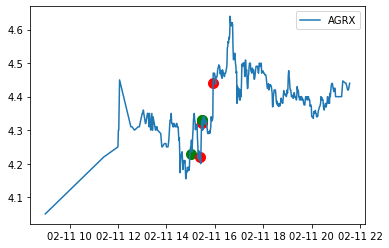

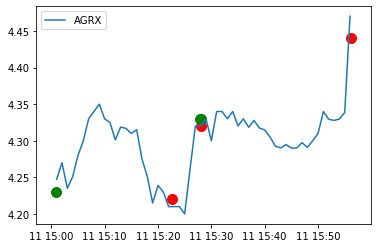

Delta = 0.08999999999999986


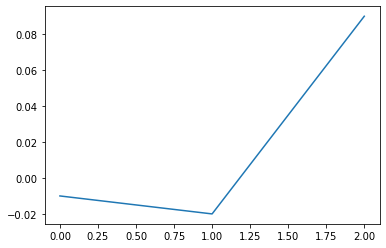

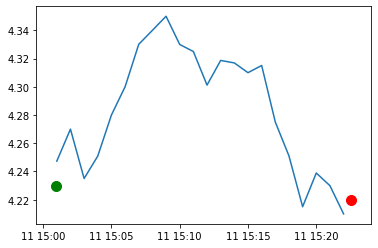

buy time:2020-02-11T15:00:58.174002512Z sell time:2020-02-11T15:22:33.561034045Z
{'rsi': 55.33227421277018, 'macd1': [0.014604310759949612, 0.014020996571084687, 0.01629194988099325, 0.018731107603787045, 0.020045762713055915], 'macd2': [0.02443992137082418, 0.024321740760195887, 0.024753080005258887, 0.025279869002807764, 0.025647330821019665], 'macd_signal': [0.022610195871230816, 0.02089235601120159, 0.01997227478515992, 0.019724041348885345, 0.01978838562171946]}
{'rsi': 38.538111702296256, 'macd': [0.012185810629662619, 0.007064993415351495, 0.004224551515688901, 0.00148882339237133, -0.0016960144101139107], 'too_close': 1, 'macd_signal': [0.018679088604751776, 0.01635626956687172, 0.013929925956635156, 0.011441705443782391, 0.00881416147300313], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.010510175883117041}
buy indicator analysis
slope:0.0015593014938914962 error=0.0003018418628380117


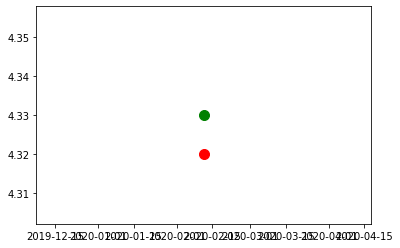

buy time:2020-02-11T15:27:54.789675538Z sell time:2020-02-11T15:27:59.724876371Z
{'rsi': 62.62904501598895, 'macd1': [-0.0030507195722053737, -0.006119720665116901, -0.009252189092154417, -0.006766776160720411, 0.0007937812774194697], 'macd2': [0.027380502808703078, 0.026038083206546325, 0.02460143393130032, 0.02420953640308543, 0.02492021438867731], 'macd_signal': [0.013196849484315046, 0.009333535454428657, 0.005616390545112041, 0.0031397572039455505, 0.0026705620186403345]}
{'rsi': 61.37035959399223, 'macd': [-0.004159660478238791, -0.006021315222362489, -0.007913236903206666, -0.006136640331096288, -0.0015868684524242838], 'too_close': 0, 'macd_signal': [0.006218565913923421, 0.0037705896866662386, 0.0014338243686916573, -8.026857126593179e-05, -0.0003815885474976022], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0012052799049266816}
buy indicator analysis
slope:0.0007041946203646177 error=0.0013514439866335018


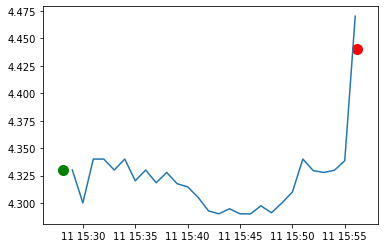

buy time:2020-02-11T15:28:03.828624289Z sell time:2020-02-11T15:56:12.397504563Z
{'rsi': 62.72247800008396, 'macd1': [-0.006119720665116901, -0.009252189092154417, -0.006766776160720411, -3.939520301088351e-06, 0.006092344907608904], 'macd2': [0.026038083206546325, 0.02460143393130032, 0.02420953640308543, 0.024760278363087806, 0.025387314003436856], 'macd_signal': [0.009333535454428657, 0.005616390545112041, 0.0031397572039455505, 0.002511017859096223, 0.0032272832687987594]}
{'rsi': 78.11660332259726, 'macd': [0.004028977650177623, 0.004597016628222761, 0.005078644187372028, 0.005845124828431025, 0.011982056174341338], 'too_close': 0, 'macd_signal': [0.003151943985538677, 0.003440958514075494, 0.003768495648734801, 0.004183821484674046, 0.005743468422607504], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0062385877517338335}
buy indicator analysis
slope:0.003367238071730494 error=0.0011698248056664906
AMRS analysis for run 55


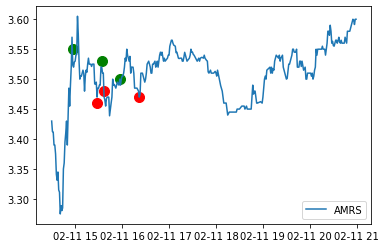

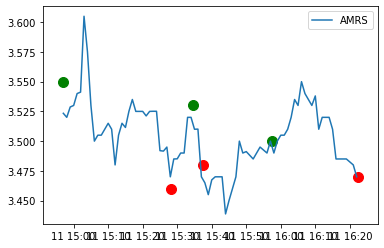

Delta = -0.16999999999999948


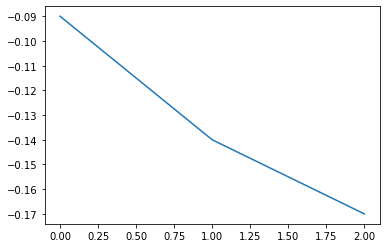

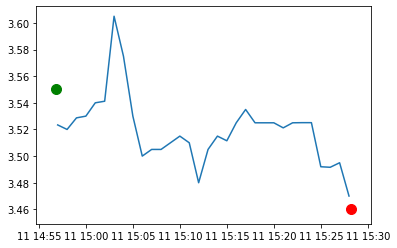

buy time:2020-02-11T14:56:52.172249208Z sell time:2020-02-11T15:28:13.673216852Z
{'rsi': 71.28127118131268, 'macd1': [0.010791097036865427, 0.018591058444660025, 0.022097113012650826, 0.027384225702528298, 0.03600080429770225], 'macd2': [0.002404053724326616, 0.004253894283827719, 0.005469195183578357, 0.007138339761584067, 0.00962220554125004], 'macd_signal': [-0.0023097467803670363, 0.0018704142646383762, 0.005915754014240867, 0.010209448351898354, 0.015367719541059133]}
{'rsi': 39.240913494461324, 'macd': [0.00723865770862675, 0.00505643100061226, 0.0032695474489048415, 0.002011332376809616, -0.000657553814132239], 'too_close': 1, 'macd_signal': [0.0096513209873336, 0.008732342989989332, 0.007639783881772434, 0.006514093580779871, 0.005079764101797449], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005737317915929688}
buy indicator analysis
slope:0.005921258177954192 error=0.0004808659699545315


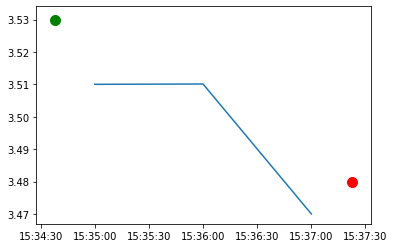

buy time:2020-02-11T15:34:38.104014494Z sell time:2020-02-11T15:37:22.405025041Z
{'rsi': 59.06836078154839, 'macd1': [-0.0008603981806607486, -0.0015003382635718765, -0.001984617949458478, 5.17397661510266e-05, 0.00244430789358141], 'macd2': [0.019049205607784447, 0.01845796683413825, 0.0178844873117483, 0.017808072145708564, 0.0178692222514103], 'macd_signal': [0.006853210684484963, 0.005182500894873595, 0.0037490771260071803, 0.0030096096540359494, 0.0028965493019450415]}
{'rsi': 43.34001030037778, 'macd': [-0.00118225068824529, -5.7027324122049805e-05, 0.00030103019758609406, 0.0005813213807663864, -0.0007714558970248753], 'too_close': 1, 'macd_signal': [0.000409293594976636, 0.00031602941115689884, 0.0003130295684427379, 0.00036668793090746763, 0.00013905916532099905], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0009105150623458743}
buy indicator analysis
slope:0.0008161490178207221 error=0.0004305944398778066


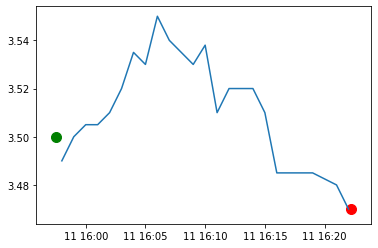

buy time:2020-02-11T15:57:32.552173618Z sell time:2020-02-11T16:22:13.503880564Z
{'rsi': 55.63777825714729, 'macd1': [-0.0032635659468991385, -0.002158379109410191, -0.000869034674233049, -0.0002478214025218861, 0.0010394291254858246], 'macd2': [0.007852391442806805, 0.007724177703886781, 0.007673831232847039, 0.007535269635568387, 0.007555672948690972], 'macd_signal': [-0.006507180455700542, -0.0056374201864424715, -0.004683743084000587, -0.0037965587477048466, -0.0028293611730667123]}
{'rsi': 36.281670548377335, 'macd': [0.0023789254051900244, 0.0006612618047361352, -0.0006857651800946662, -0.0019862308152864827, -0.0034932659749773443], 'too_close': 1, 'macd_signal': [0.005308102337447173, 0.004378734230904966, 0.0033658343487050395, 0.002295421315906735, 0.001137683857729919], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004630949832707263}
buy indicator analysis
slope:0.0010516547851658232 error=5.718867079071996e-05
NBR anal

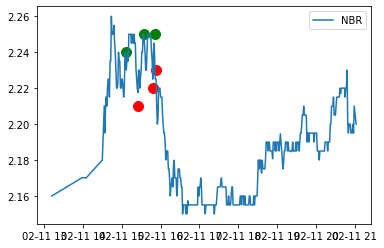

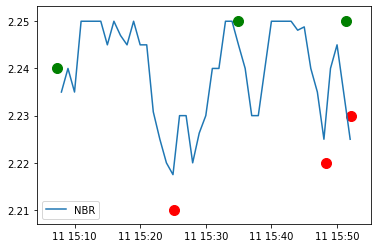

Delta = -0.08000000000000007


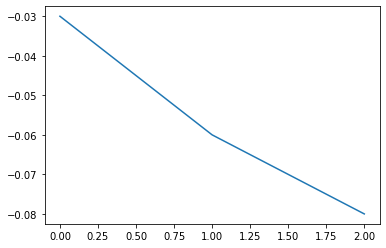

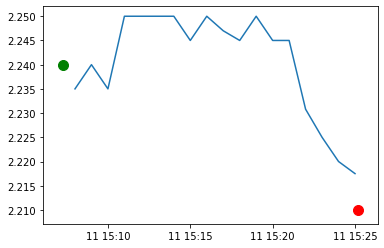

buy time:2020-02-11T15:07:15.491202999Z sell time:2020-02-11T15:25:09.618034989Z
{'rsi': 59.26780552394604, 'macd1': [0.003818311228465099, 0.0031731292376040443, 0.0042269253503186555, 0.0045975413890517736, 0.005242354053140996], 'macd2': [0.011055688465704261, 0.010822289850850986, 0.010910118970330895, 0.010891907985941529, 0.010939300586091605], 'macd_signal': [0.008267943215497772, 0.007248980419919027, 0.006644569405998953, 0.006235163802609517, 0.006036601852715813]}
{'rsi': 36.39546288846917, 'macd': [0.0034094297942677265, 0.0024007632266926926, 0.0012823118334304162, 0.00013439760707711912, -0.0010215666940687207], 'too_close': 1, 'macd_signal': [0.0037947104198886366, 0.0035159209812494477, 0.0030691991516856414, 0.002482238842763937, 0.0017814777353974054], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002803044429466126}
buy indicator analysis
slope:0.00042724978007995244 error=0.0001436794305556617


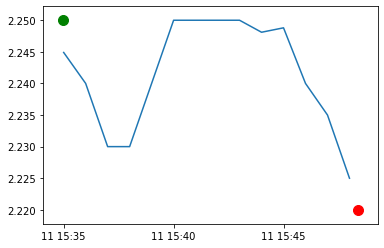

buy time:2020-02-11T15:34:57.766249046Z sell time:2020-02-11T15:48:22.561749747Z
{'rsi': 61.468753182975746, 'macd1': [-0.0019745640658155317, -0.0010358388905049587, -0.0002885660165095061, 0.0010979134832478366, 0.002323241712593127], 'macd2': [0.007459757487195073, 0.0073925692811913635, 0.007318930601007523, 0.007399411078613749, 0.007492009213222683], 'macd_signal': [8.646829099465288e-05, -0.00013799314530526946, -0.00016810771954611678, 8.509652101267387e-05, 0.0005327255593287646]}
{'rsi': 36.466823247354164, 'macd': [0.0022675250949779624, 0.002326864482502078, 0.0018857410898904803, 0.0012577781724028014, -2.7099142164477286e-05], 'too_close': 1, 'macd_signal': [0.0014709094214854373, 0.0016421004336887655, 0.0016908285649291084, 0.001604218486423847, 0.0012779549607061821], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0013050541028706594}
buy indicator analysis
slope:0.0010729363930570112 error=6.906300136495756e-05


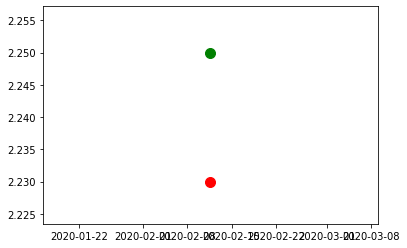

buy time:2020-02-11T15:51:22.537961109Z sell time:2020-02-11T15:52:09.735930517Z
{'rsi': 56.61195508470915, 'macd1': [0.0022505221892181737, 0.0006745033727719729, 0.0006286253442429057, 0.000984377597170294, 0.0016507432928007937], 'macd2': [0.006289056654803282, 0.005886933454975374, 0.0057474559593235774, 0.005689907961989871, 0.005707829763784034], 'macd_signal': [0.0027933277472553418, 0.002369562872358668, 0.0020213753667355154, 0.001813975812822471, 0.0017813293088181355]}
{'rsi': 44.36540365595052, 'macd': [0.00023264111757592687, 0.00021003248891116044, 0.0004494279407447621, 0.00011065260528075882, -0.00041450548216204197], 'too_close': 1, 'macd_signal': [0.001329903012654263, 0.0011059289079056425, 0.0009746287144734665, 0.0008018334926349249, 0.0005585656976755315], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0009730711798375735}
buy indicator analysis
slope:-8.896835684364391e-05 error=0.00024963937094091455
ABEO ana

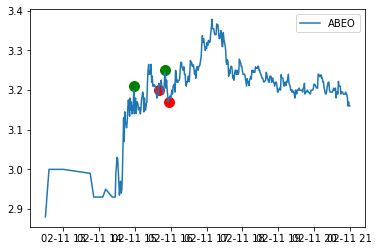

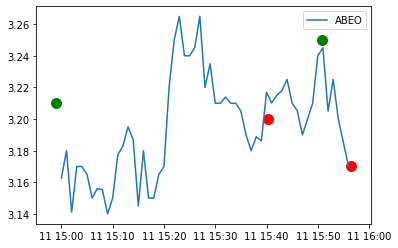

Delta = -0.08999999999999986


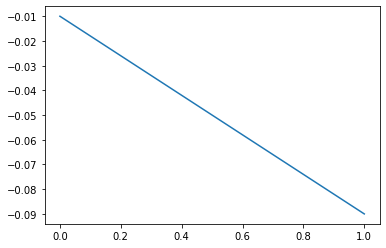

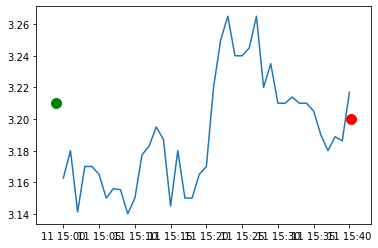

buy time:2020-02-11T14:59:01.546537043Z sell time:2020-02-11T15:40:14.42886871Z
{'rsi': 66.30307898645948, 'macd1': [0.05569127425326714, 0.05368849721507507, 0.05071779159010914, 0.05179296192279814, 0.05364054025270759], 'macd2': [0.04297285181655219, 0.0435444536751417, 0.04384236573508282, 0.044844415390014714, 0.04601448280082554], 'macd_signal': [0.054564490029532085, 0.054389291466640684, 0.053654991491334375, 0.05328258557762713, 0.05335417651264322]}
{'rsi': 48.118952188636, 'macd': [0.004787308449459626, 0.002746579121219117, 0.0015778734223146351, 0.0005116368592421594, -0.00012843886340219157], 'too_close': 0, 'macd_signal': [0.00944245167363673, 0.008103277163153209, 0.006798196414985494, 0.0055408845038368276, 0.004407019830389024], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0045354586937912155}
buy indicator analysis
slope:-0.0005997003293396031 error=0.0006093680490516743


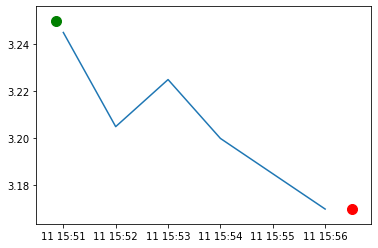

buy time:2020-02-11T15:50:51.56070159Z sell time:2020-02-11T15:56:30.266817093Z
{'rsi': 62.039204505676814, 'macd1': [0.005258127670515478, 0.0033031676938408694, 0.0025315817554902864, 0.0026959337211076573, 0.005984859805610032], 'macd2': [0.02793785960797157, 0.027011879100379055, 0.026276681713584882, 0.025718186746024774, 0.02580296496779999], 'macd_signal': [0.0068159460811844565, 0.0061133904037157395, 0.005397028674070649, 0.00485680968347805, 0.005082419707904446]}
{'rsi': 41.7012931478179, 'macd': [0.003965022984520505, 0.0030333321701081495, 0.00330690644238274, 0.0021784330643837, -0.0002876297374903025], 'too_close': 1, 'macd_signal': [0.0024017182043245327, 0.002528040997481256, 0.002683814086461553, 0.002582737882045982, 0.002008664358138725], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0022962940956290276}
buy indicator analysis
slope:8.462302974558966e-05 error=0.0005710549996811342
VSLR analysis for run 55


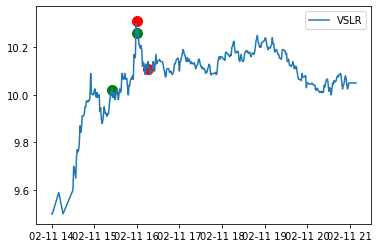

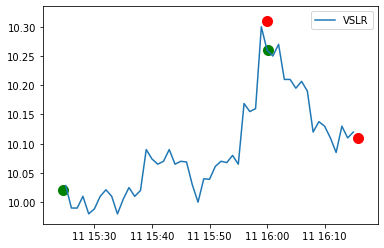

Delta = 0.14000000000000057


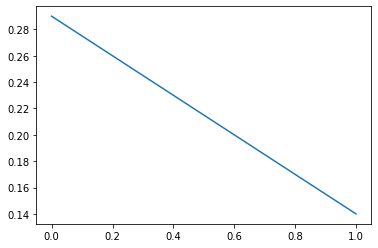

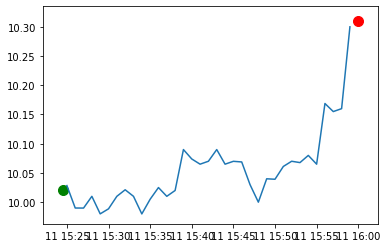

buy time:2020-02-11T15:24:29.703206511Z sell time:2020-02-11T15:59:55.398404925Z
{'rsi': 66.22421619467185, 'macd1': [0.0018619541252213878, 0.0035127075356324866, 0.007159164395234896, 0.011186910773611558, 0.01615352789885094], 'macd2': [0.05745552398536802, 0.05647209253641883, 0.05595679300256151, 0.05564430543781995, 0.05565645613425296], 'macd_signal': [0.01124248143108127, 0.009696526651991513, 0.00918905420064019, 0.009588625515234464, 0.010901605991957759]}
{'rsi': 78.72336460301416, 'macd': [0.00969859037017251, 0.014659150315194935, 0.017617260008522706, 0.019953225223991566, 0.02931172766170853], 'too_close': 0, 'macd_signal': [0.010543808567676881, 0.011366876917180493, 0.012616953535448935, 0.014084207873157461, 0.017129711830867676], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.012182015830840855}
buy indicator analysis
slope:0.0036257350785238174 error=0.0003508139271332955


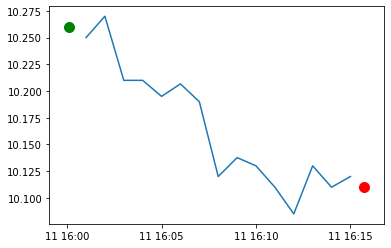

buy time:2020-02-11T16:00:05.21872922Z sell time:2020-02-11T16:15:43.362502212Z
{'rsi': 74.39958073615423, 'macd1': [0.025204583611067477, 0.02975490950279358, 0.03337975275696259, 0.04700742479077746, 0.055553237070366634], 'macd2': [0.04214834052372929, 0.04285581795929261, 0.04351814595105452, 0.046297012054708375, 0.048459740106002513], 'macd_signal': [0.020271060800036128, 0.02216783054058762, 0.024410214983862612, 0.02892965694524558, 0.03425437297026979]}
{'rsi': 48.199714551123726, 'macd': [0.0094680450307294, 0.004772420315335424, 0.0033891748187269144, 0.0012283448886574178, -3.838756702734258e-06], 'too_close': 0, 'macd_signal': [0.020710332338129554, 0.01752274993357073, 0.014696034910601966, 0.012002496906213056, 0.009601229773629897], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009605068530332632}
buy indicator analysis
slope:0.00779498222065822 error=0.00107271105897004
RMTI analysis for run 55


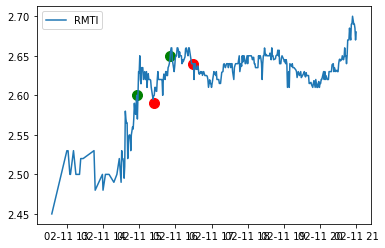

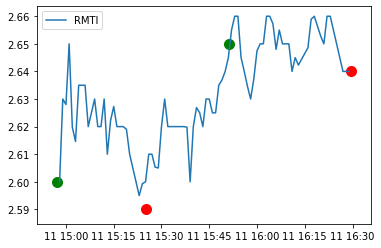

Delta = -0.020000000000000018


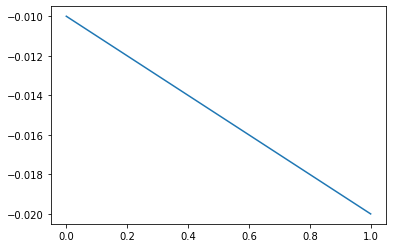

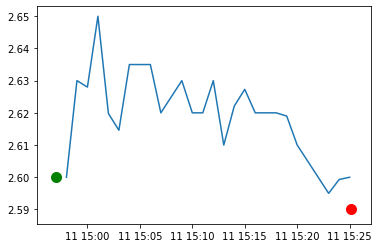

buy time:2020-02-11T14:57:02.756933012Z sell time:2020-02-11T15:25:09.296550583Z
{'rsi': 64.8223269966114, 'macd1': [0.03028770347675236, 0.030055509170112682, 0.029211989309695596, 0.030132741677634467, 0.03051073579294128], 'macd2': [0.025135567740179, 0.025601353088819945, 0.025924970311877793, 0.02656509160296494, 0.027111536514752288], 'macd_signal': [0.03152071550778365, 0.03122767424024946, 0.03082453725413869, 0.030686178138837845, 0.030651089669658533]}
{'rsi': 44.8074844577779, 'macd': [0.003993680262366794, 0.002764470455565604, 0.0015110021586353106, 0.000738026834291805, -9.725298772034208e-05], 'too_close': 0, 'macd_signal': [0.007610245918683196, 0.006641090826059678, 0.0056150730925748045, 0.0046396638409182045, 0.003692280475190495], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003789533462910837}
buy indicator analysis
slope:5.232971398996256e-05 error=0.00017795206443425765


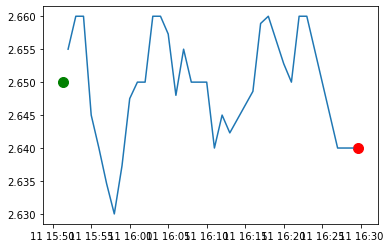

buy time:2020-02-11T15:51:19.080081973Z sell time:2020-02-11T16:29:36.421126777Z
{'rsi': 67.04911460605985, 'macd1': [0.004482842760201056, 0.005119835431765196, 0.005712125012828029, 0.006358367561947631, 0.007589943717959624], 'macd2': [0.016477206099105413, 0.016325900984970332, 0.016190972287823513, 0.016090518540807786, 0.016132299370057446], 'macd_signal': [0.004224466541354609, 0.004403540319436726, 0.004665257258114987, 0.005003879318881516, 0.005521092198697138]}
{'rsi': 44.03286298565173, 'macd': [0.0024165682422903068, 0.002018407305362402, 0.0011624584284657402, 0.00048038841492958895, -5.733352308423534e-05], 'too_close': 1, 'macd_signal': [0.002428268860732396, 0.0023462965496583972, 0.002109528925419866, 0.0017837008233218105, 0.0014154939540406014], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0014728274771248367}
buy indicator analysis
slope:0.0007452734045699573 error=7.135628290506889e-05
ICAD analysis for run 5

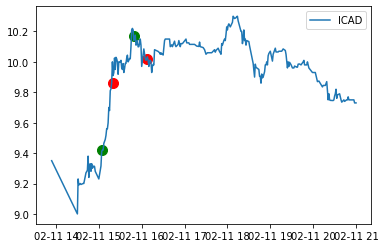

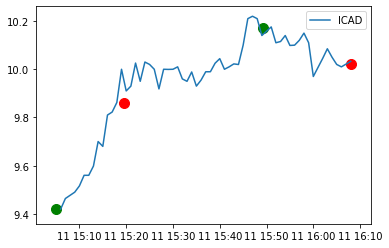

Delta = 0.28999999999999915


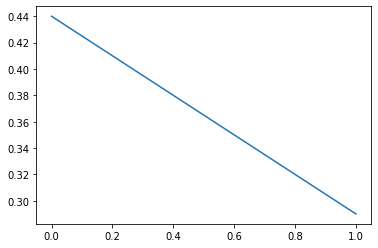

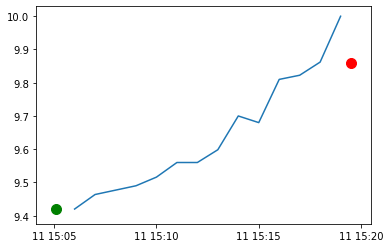

buy time:2020-02-11T15:05:05.196138998Z sell time:2020-02-11T15:19:30.982391562Z
{'rsi': 64.49080110579791, 'macd1': [0.11357516013169189, 0.10186672212057779, 0.09831319693100937, 0.10198706526475299, 0.10450092717563919], 'macd2': [0.0745520415588743, 0.07459868848019013, 0.0758817511799208, 0.0784602398913794, 0.08086698182080987], 'macd_signal': [0.12034526984829307, 0.11664956030275, 0.11298228762840187, 0.11078324315567209, 0.1095267799596655]}
{'rsi': 80.79163680547718, 'macd': [0.07947069429341447, 0.0820930688776027, 0.08982358064609208, 0.09533016669106864, 0.1004401017041534], 'too_close': 0, 'macd_signal': [0.07038086705889574, 0.07272330742263713, 0.07614336206732812, 0.07998072299207623, 0.08407259873449166], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.016367502969661746}
buy indicator analysis
slope:-0.00180281227679302 error=0.001829061614335885


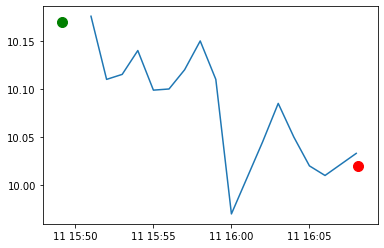

buy time:2020-02-11T15:49:10.025390796Z sell time:2020-02-11T16:08:04.891965311Z
{'rsi': 72.31437685799469, 'macd1': [0.07326717250025716, 0.0758920086801993, 0.0858585668419174, 0.09348639939777215, 0.09716078217631718], 'macd2': [0.1451354498926012, 0.14485059301721748, 0.14611614358006264, 0.14720673425210684, 0.14772677511550825], 'macd_signal': [0.09086919215094016, 0.08787375545679199, 0.08747071773381707, 0.08867385406660808, 0.0903712396885499]}
{'rsi': 46.24436921303975, 'macd': [0.011456254173786817, 0.00849401734410371, 0.004517027381440997, 0.000839930951036294, -0.002036247188902607], 'too_close': 0, 'macd_signal': [0.024800195994247494, 0.021538960264218737, 0.018134573687663188, 0.014675645140337808, 0.011333266674489726], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.013369513863392333}
buy indicator analysis
slope:0.00653816100696929 error=0.0006755630273206855
OILU analysis for run 55


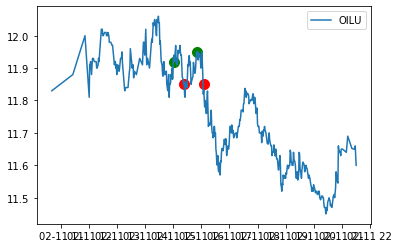

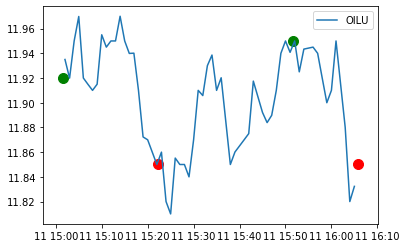

Delta = -0.16999999999999993


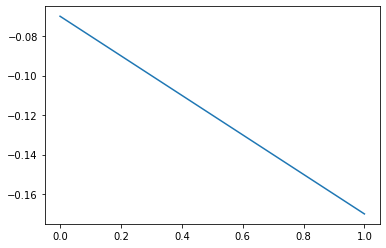

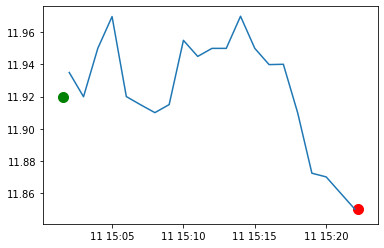

buy time:2020-02-11T15:01:33.170936547Z sell time:2020-02-11T15:22:12.369839055Z
{'rsi': 55.3841136739754, 'macd1': [0.055771088291360016, 0.051943823660659305, 0.04872823087409195, 0.050463840732204446, 0.05084970212266704], 'macd2': [0.07884039504349616, 0.07833199294110571, 0.07781413560029549, 0.07817765168042179, 0.07830709586020923], 'macd_signal': [0.07256232369586887, 0.06843862368882696, 0.06449654512587996, 0.06169000424714486, 0.0595219438222493]}
{'rsi': 36.196562315687295, 'macd': [0.012411201704082941, 0.00806703289768329, 0.004457719114803638, 0.0010678938409398597, -0.0021068777210437872], 'too_close': 1, 'macd_signal': [0.01762299960171567, 0.015711806260909195, 0.013460988831688083, 0.010982369833538438, 0.008364520322621994], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.010471398043665781}
buy indicator analysis
slope:-0.001132275526584081 error=0.000702014622127303


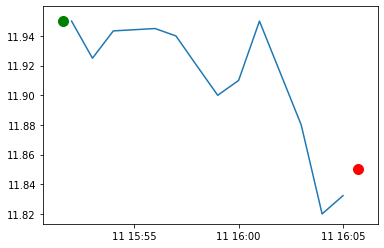

buy time:2020-02-11T15:51:34.279818027Z sell time:2020-02-11T16:05:42.775727342Z
{'rsi': 60.379735627516794, 'macd1': [0.0013217713084081595, 0.0013891154035210462, 0.0030374435076279127, 0.006687416312752603, 0.010268592541125443], 'macd2': [0.033147177234832625, 0.032286668930684215, 0.0317664065222214, 0.0317167506133984, 0.03178027510414161], 'macd_signal': [0.0009353336355824143, 0.0010260899891701408, 0.0014283606928616951, 0.0024801718168398768, 0.00403785596169699]}
{'rsi': 39.942157534915665, 'macd': [0.006164254030377236, 0.004975562979044668, 0.006062614588667969, 0.0031945689002093047, -0.0006402013622270886], 'too_close': 1, 'macd_signal': [0.0071766584961955125, 0.006736439392765343, 0.006601674431945868, 0.005920253325598555, 0.004608162388033426], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005248363750260515}
buy indicator analysis
slope:0.0023191943374666125 error=0.00045402964191460686
NAT analysis for run 55


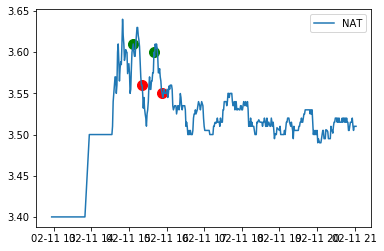

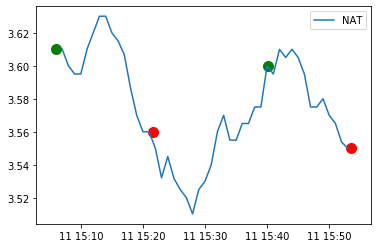

Delta = -0.10000000000000009


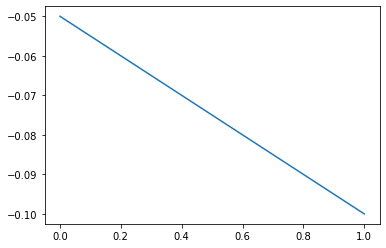

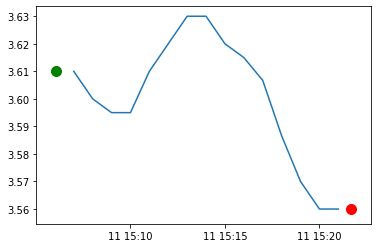

buy time:2020-02-11T15:06:03.655180677Z sell time:2020-02-11T15:21:41.233355169Z
{'rsi': 61.94164430801538, 'macd1': [0.021955261344198895, 0.01826448787574142, 0.01715901592323732, 0.01769280267357498, 0.018707105082830022], 'macd2': [0.0345049251474161, 0.03380666079653194, 0.033510006292505334, 0.03350335213859301, 0.033603582199885906], 'macd_signal': [0.03506890224229509, 0.03170801936898436, 0.028798218679834953, 0.02657713547858296, 0.02500312939943237]}
{'rsi': 40.22015435426612, 'macd': [0.008617663664222341, 0.006684648568014762, 0.004229251758398611, 0.001741549676121057, -0.00021953700716181856], 'too_close': 1, 'macd_signal': [0.0096626387926459, 0.009067040747719673, 0.00809948294985546, 0.006827896295108579, 0.0054184096346545], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005637946641816318}
buy indicator analysis
slope:-0.0007067997724904186 error=0.0005527004972523619


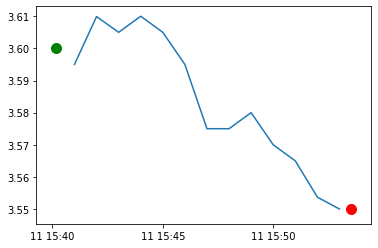

buy time:2020-02-11T15:40:09.881800003Z sell time:2020-02-11T15:53:32.216611212Z
{'rsi': 63.82531746102571, 'macd1': [-0.005597800000499031, -0.004154510004166223, -0.002178661602433518, -0.0006058041754068988, 0.0026276972751166916], 'macd2': [0.013641556045542291, 0.013343382310503582, 0.013207648086766444, 0.013061644471745737, 0.013306266264609068], 'macd_signal': [-0.009122834092555047, -0.008129169274877283, -0.00693906774038853, -0.005672415027392204, -0.004012392566890425]}
{'rsi': 39.75643573313164, 'macd': [0.0041285558489394525, 0.003027117697219417, 0.0018698007257849092, 0.0003566991801764452, -0.0010087916239363004], 'too_close': 1, 'macd_signal': [0.004445310715005644, 0.004161672111448399, 0.003703297834315701, 0.00303397810348785, 0.0022254241580030197], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00323421578193932}
buy indicator analysis
slope:0.001999970037999077 error=0.00018045381355151483
AGTC analysis for r

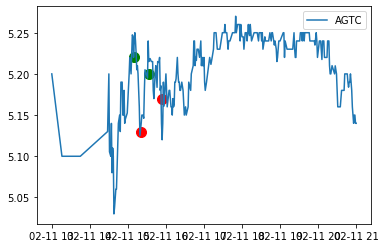

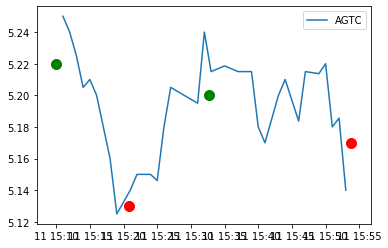

Delta = -0.1200000000000001


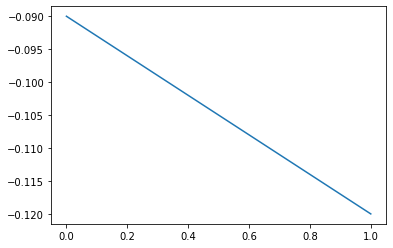

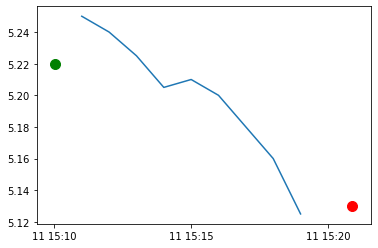

buy time:2020-02-11T15:10:02.151957721Z sell time:2020-02-11T15:20:52.985718204Z
{'rsi': 58.59120176591395, 'macd1': [0.018008152293918833, 0.018822503546426894, 0.023027223148289977, 0.02593146530760393, 0.0262520941753559], 'macd2': [-0.00440142115188813, -0.0035093226839730818, -0.001924854125232578, -0.0004896035973791513, 0.0004989889172071216], 'macd_signal': [0.008550701729959753, 0.010605062093253181, 0.01308949430426054, 0.015657888504929218, 0.017776729639014555]}
{'rsi': 39.32272493438687, 'macd': [0.013340964170363456, 0.011409534513066255, 0.008717387578640157, 0.005467436881961163, 0.001305560535432626], 'too_close': 1, 'macd_signal': [0.014867893015604972, 0.014176221315097229, 0.013084454567805815, 0.011561051030636885, 0.009509952931596033], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.008204392396163407}
buy indicator analysis
slope:0.0023596845524051172 error=0.00037007375315069725


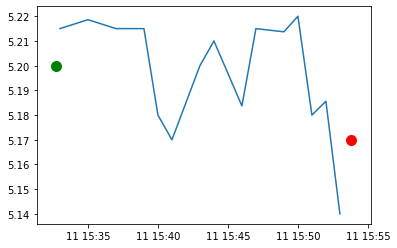

buy time:2020-02-11T15:32:44.728541258Z sell time:2020-02-11T15:53:49.370685584Z
{'rsi': 54.42865183135041, 'macd1': [-0.005580472731418595, -0.002392900135272491, -0.00026710507977067977, 0.0010025874005199498, 0.0023847956127074355], 'macd2': [0.0010941405371562851, 0.00155905794704303, 0.0019043353274357244, 0.0021389878308237797, 0.0024314226404893446], 'macd_signal': [0.0017537606417013405, 0.0009244284863065741, 0.0006861217730911234, 0.0007494148985768887, 0.001076491041402998]}
{'rsi': 44.58790350332035, 'macd': [0.003023215236254373, 0.003726843428180082, 0.0021488024942497574, 0.001182162773080364, -0.00039680535735175937], 'too_close': 1, 'macd_signal': [0.002832262380963035, 0.0030111785904064444, 0.002838703371175107, 0.0025073952515561582, 0.0019265551297745747], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002323360487126334}
buy indicator analysis
slope:0.0019326024224044502 error=0.00022886650986767877
UWT analysi

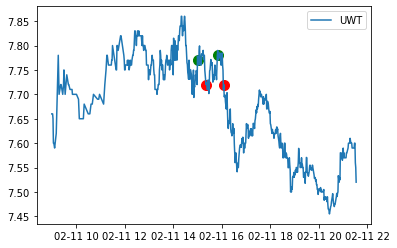

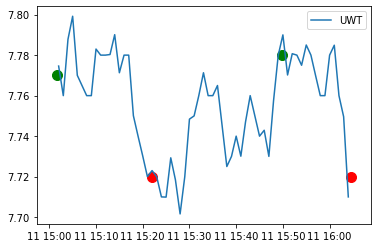

Delta = -0.11000000000000032


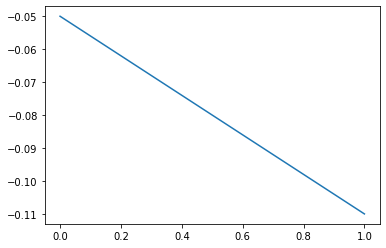

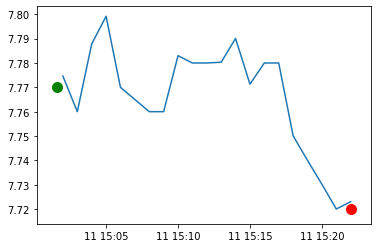

buy time:2020-02-11T15:01:33.318621999Z sell time:2020-02-11T15:22:02.462244167Z
{'rsi': 54.405066963070915, 'macd1': [0.036406144865197554, 0.03480736887189373, 0.03157063703814522, 0.033333646148021145, 0.033664965010197], 'macd2': [0.05142617601084609, 0.051276833097529284, 0.050739150020387314, 0.05109734059992199, 0.05121081807337635], 'macd_signal': [0.048008186532788315, 0.045368023000609395, 0.04260854580811656, 0.04075356587609748, 0.039335845702917385]}
{'rsi': 38.0861853865815, 'macd': [0.0073474423766830554, 0.005065420899926565, 0.002712346750506356, 0.00031368706588619233, -0.001523108624283509], 'too_close': 1, 'macd_signal': [0.010961420116378521, 0.00978222027308813, 0.008368245568571775, 0.006757333868034658, 0.005101245369571024], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.006624353993854533}
buy indicator analysis
slope:-0.000695608243387369 error=0.0005180511927822964


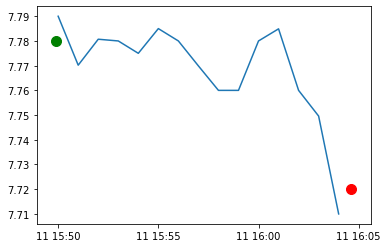

buy time:2020-02-11T15:49:54.708292946Z sell time:2020-02-11T16:04:38.293583698Z
{'rsi': 59.690713360582784, 'macd1': [0.0009607504213215989, 0.000760796065784497, -0.00043359319927471773, 0.0008293051622798586, 0.0036041764693415246], 'macd2': [0.020652922696709375, 0.020070539320953706, 0.01929631049052638, 0.018992957519404996, 0.01904334255873774], 'macd_signal': [0.0007770706375336225, 0.0007738157231837974, 0.0005323339386920944, 0.0005917281834096472, 0.0011942178405960227]}
{'rsi': 38.44047884124379, 'macd': [0.004236769331063428, 0.004679112735923141, 0.0036695217171658356, 0.002294911550378309, -0.0002293939243962484], 'too_close': 1, 'macd_signal': [0.004593914834260937, 0.004610954414593378, 0.00442266787510787, 0.003997116610161958, 0.0031518145032503166], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003381208427646565}
buy indicator analysis
slope:0.0005355361192535213 error=0.00044544873647522904
BNED analysis for r

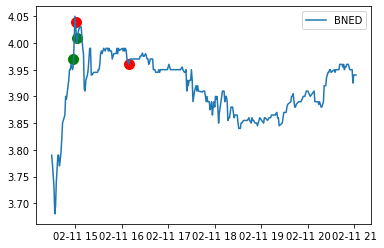

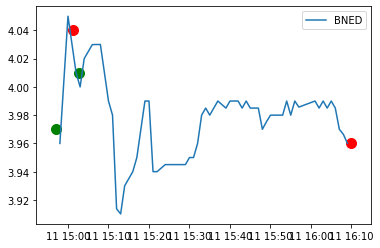

Delta = 0.020000000000000018


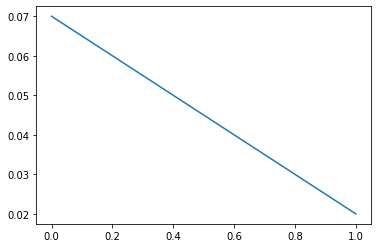

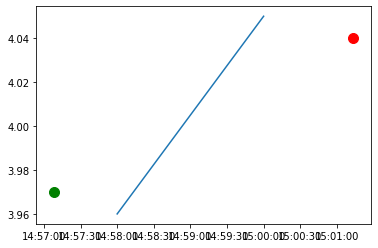

buy time:2020-02-11T14:57:08.300024463Z sell time:2020-02-11T15:01:12.869481546Z
{'rsi': 74.72386449303606, 'macd1': [0.034615303664473185, 0.03992343368482265, 0.045222698701508524, 0.04885918612254159, 0.05274692770742506], 'macd2': [0.0002534933742714962, 0.0025312366749901116, 0.004942657062136924, 0.007153335863646859, 0.009495662364574553], 'macd_signal': [0.018655651116089064, 0.02290920762983578, 0.02737190584417033, 0.03166936189984458, 0.03588487506136068]}
{'rsi': 80.38387441780645, 'macd': [0.029150014187672824, 0.03131375200824715, 0.032593109374821516, 0.033686204603647685, 0.03825632809878998], 'too_close': 0, 'macd_signal': [0.01804326504593846, 0.0206973624384002, 0.023076511825684463, 0.025198450381277108, 0.027810025924779682], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0104463021740103}
buy indicator analysis
slope:0.004519900052362269 error=0.00023361942488135776


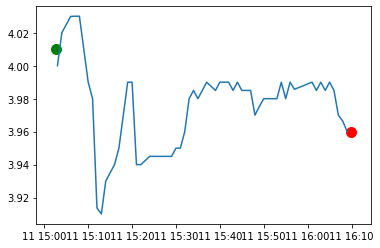

buy time:2020-02-11T15:02:45.733316306Z sell time:2020-02-11T16:09:55.273931232Z
{'rsi': 71.66830887079512, 'macd1': [0.04885918612254159, 0.05115148611198306, 0.05316224552123794, 0.06131127644847467, 0.06380625764276582], 'macd2': [0.007153335863646859, 0.009175790313395105, 0.011181773731074873, 0.01444888318695492, 0.01679187532019455], 'macd_signal': [0.03166936189984458, 0.03556578674227227, 0.039085078498065404, 0.04353031808814726, 0.04758550599907097]}
{'rsi': 40.67262872464119, 'macd': [0.003036370290754764, 0.002734657782508698, 0.0016848213113749289, 0.0006578731350193046, -0.0004833575625959874], 'too_close': 1, 'macd_signal': [0.0035339352596155003, 0.0033740797641941397, 0.0030362280736302974, 0.002560557085908099, 0.0019517741562072818], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002435131718803269}
buy indicator analysis
slope:0.004005393337694008 error=0.0005967469385474601
FLDM analysis for run 55


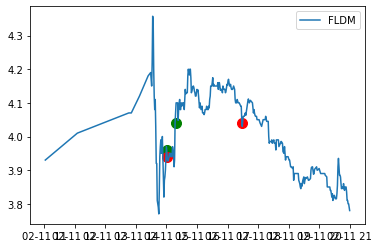

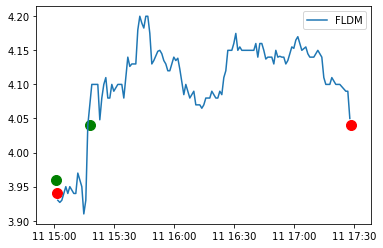

Delta = -0.020000000000000018


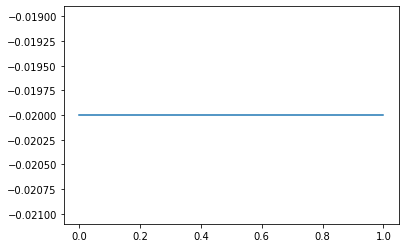

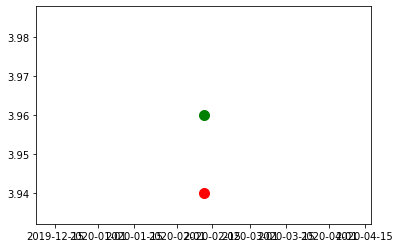

buy time:2020-02-11T15:01:19.767472294Z sell time:2020-02-11T15:01:36.48456957Z
{'rsi': 48.99645260585043, 'macd1': [0.001195820810973025, -0.002509378308259702, -0.0037882735918945976, 0.000836959716846053, 0.003653459206978127], 'macd2': [0.02609550546632544, 0.024826200184436598, 0.02393856473686995, 0.024203177522236885, 0.024247984123212163], 'macd_signal': [0.010790077196991236, 0.008130186095941048, 0.005746494158373919, 0.004764587270068345, 0.004542361657450302]}
{'rsi': 47.427633878265816, 'macd': [-0.0016542538865116363, -0.003913950580974657, -0.004584961634049645, -0.0014119187970424996, -0.0004795228357767911], 'too_close': 0, 'macd_signal': [0.004135922238912169, 0.002525947674934804, 0.0011037658131379142, 0.0006006288911018315, 0.000384598545726107], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0008641213815028981}
buy indicator analysis
slope:0.0008261614817115959 error=0.0009870166589579334


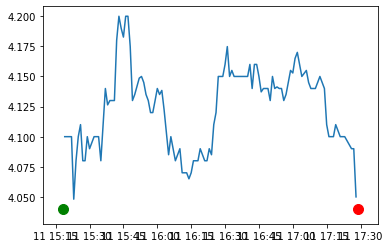

buy time:2020-02-11T15:18:09.723806639Z sell time:2020-02-11T17:28:39.367346745Z
{'rsi': 59.72643572362254, 'macd1': [0.0075483336528852085, 0.004299243673929087, 0.0033001077226226805, 0.011254629610087274, 0.017358546990749346], 'macd2': [0.020796431929124726, 0.019889105138576113, 0.019342397675318868, 0.020567770140869968, 0.02166225673130162], 'macd_signal': [0.005695976976948106, 0.005416630316344302, 0.004993325797599977, 0.006245586560097436, 0.008468178646227818]}
{'rsi': 20.754452830624817, 'macd': [-0.006651344088687061, -0.0072566059519951764, -0.00815347745649575, -0.008746449051477256, -0.011692317189754498], 'too_close': 1, 'macd_signal': [-0.0030734458459746104, -0.0039100778671787234, -0.004758757785042129, -0.005556296038329155, -0.006783500268614223], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004908816921140274}
buy indicator analysis
slope:0.0026575812611886462 error=0.0014225259845456989
MRKR analysis for r

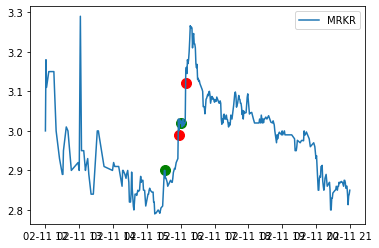

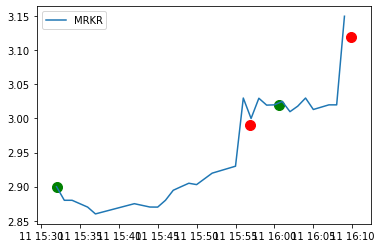

Delta = 0.1900000000000004


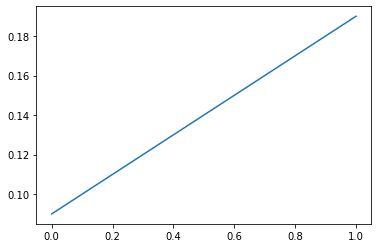

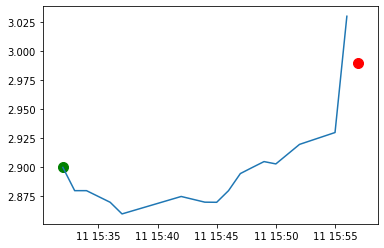

buy time:2020-02-11T15:31:59.954165506Z sell time:2020-02-11T15:56:55.406162605Z
{'rsi': 66.43195310062333, 'macd1': [-0.004797086562629005, -0.006199241620726159, -0.006158203656321248, -0.005657012047100007, 0.0019796139948491387], 'macd2': [0.020055715788705797, 0.019153166261573595, 0.018506473287971836, 0.017961864561298668, 0.01887150385025471], 'macd_signal': [0.004391639697001192, 0.0022734634334557217, 0.0005871300155003275, -0.0006616983970197396, -0.00013343591864596399]}
{'rsi': 79.77879002931132, 'macd': [0.011303525389992242, 0.011674665948814056, 0.012684974618690337, 0.013837358327442484, 0.01818158773260725], 'too_close': 0, 'macd_signal': [0.008654003564696668, 0.009258136041520145, 0.009943503756954183, 0.010722274671051843, 0.012214137283362925], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005967450449244327}
buy indicator analysis
slope:0.001409563068858244 error=0.0009768013146411341


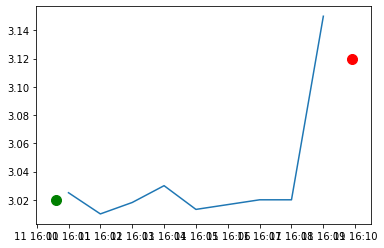

buy time:2020-02-11T16:00:36.16214081Z sell time:2020-02-11T16:09:53.170797815Z
{'rsi': 73.83547048910395, 'macd1': [0.0320205100800135, 0.03642893697841565, 0.04183691888481711, 0.04479146973587422, 0.047417497100823436], 'macd2': [0.024872878776815988, 0.026257499704320786, 0.027964410042334187, 0.029328561600750813, 0.030701451840460248], 'macd_signal': [0.02080923982972003, 0.023933179259459154, 0.027513927184530745, 0.03096943569479944, 0.03425904797600424]}
{'rsi': 78.78029035939409, 'macd': [0.028449902176599817, 0.02714210238039394, 0.026123789521267593, 0.02499102898790584, 0.02897860481920933], 'too_close': 0, 'macd_signal': [0.02558194811242402, 0.025893978966018007, 0.025939941077067923, 0.025750158659235505, 0.02639584789123027], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00258275692797906}
buy indicator analysis
slope:0.003915650679907845 error=0.00032700292251770254
KZR analysis for run 55


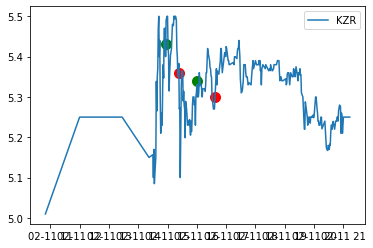

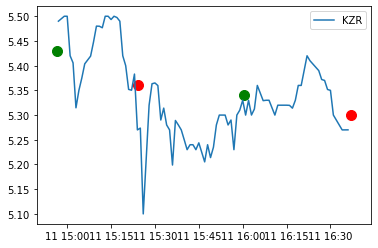

Delta = -0.10999999999999943


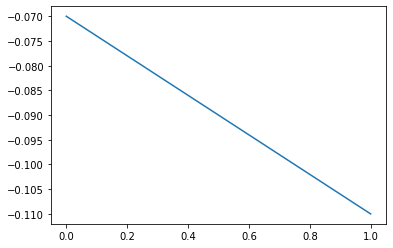

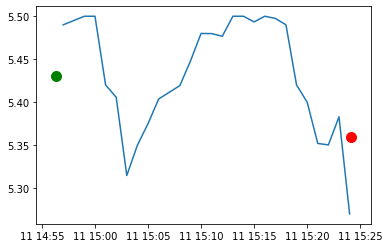

buy time:2020-02-11T14:56:21.694224992Z sell time:2020-02-11T15:24:08.659085685Z
{'rsi': 59.50048542534476, 'macd1': [0.05163138521496968, 0.05136184823850609, 0.06034540931690646, 0.06673600093882293, 0.06938690889401311], 'macd2': [0.05866707974498819, 0.059053073727862504, 0.06127456907359807, 0.06322841254190692, 0.06460501396950047], 'macd_signal': [0.060467366153401446, 0.058646262570422374, 0.058986091919719194, 0.06053607372353994, 0.06230624075763457]}
{'rsi': 43.90815796175563, 'macd': [0.0203397285302076, 0.015225909431195284, 0.00854986975104044, 0.003148411951555019, -0.000327378696765912], 'too_close': 1, 'macd_signal': [0.025058078608737884, 0.023091644773229364, 0.02018328976879158, 0.016776314205344266, 0.01335557562492223], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.013682954321688142}
buy indicator analysis
slope:0.005088520005840369 error=0.0008014593041272269


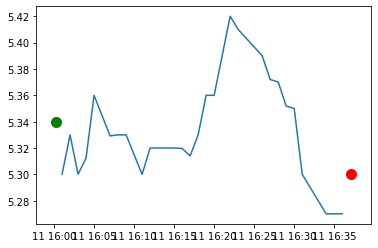

buy time:2020-02-11T16:00:16.748015989Z sell time:2020-02-11T16:37:07.479688207Z
{'rsi': 57.268511001052666, 'macd1': [-0.006146582798137956, -0.009116391473305896, -0.00575522856669064, -0.0022585313769871718, 0.0028999468357664426], 'macd2': [0.002949965073517191, 0.001909503832641768, 0.00206874440417959, 0.002371878181665288, 0.0031267855424275126], 'macd_signal': [-0.016875367505495502, -0.015323572299057581, -0.013409903552584193, -0.011179629117464788, -0.008363713926818542]}
{'rsi': 43.63658988220711, 'macd': [0.01213667780254113, 0.010353990581728922, 0.00623301364886597, 0.001382473004442275, -0.0008566816925688059], 'too_close': 1, 'macd_signal': [0.012495140127721821, 0.012066910218523241, 0.010900130904591788, 0.008996599324561885, 0.007025943121135747], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.007882624813704553}
buy indicator analysis
slope:0.0024950919364127525 error=0.0008607139397554377
DEAC analysis for run 

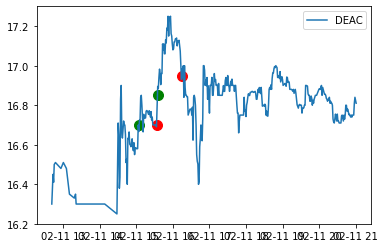

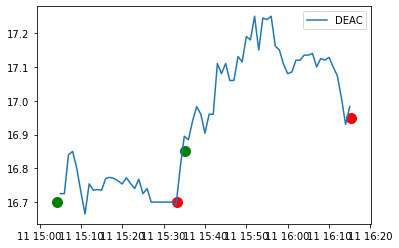

Delta = 0.09999999999999787


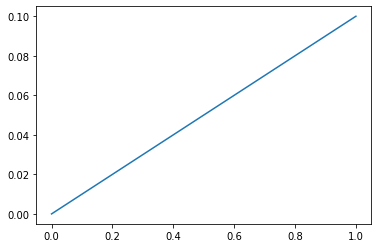

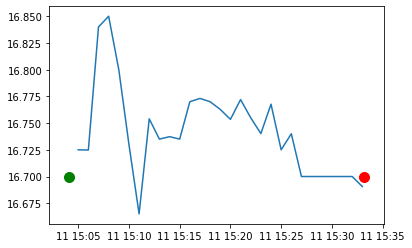

buy time:2020-02-11T15:04:06.797185245Z sell time:2020-02-11T15:33:09.920048754Z
{'rsi': 59.47907286497537, 'macd1': [0.05103544806935645, 0.04658571228200614, 0.04256856074169235, 0.048508757560629334, 0.05260995156337955], 'macd2': [0.0954014897406914, 0.09420110683217686, 0.09294605465311889, 0.09356194458409561, 0.09397894376556337], 'macd_signal': [0.07468038141668229, 0.06906144758974705, 0.06376287022013612, 0.06071204768823476, 0.05909162846326372]}
{'rsi': 46.15066192884157, 'macd': [0.007380097455246926, 0.00494650301862265, 0.0029859553664657312, 0.001419477256128232, -0.0003390703266816786], 'too_close': 0, 'macd_signal': [0.01652744766029713, 0.014211258731962235, 0.011966198058862934, 0.009856853898315993, 0.007817669053316458], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.008156739379998137}
buy indicator analysis
slope:0.0005072052266669403 error=0.0014060607558441295


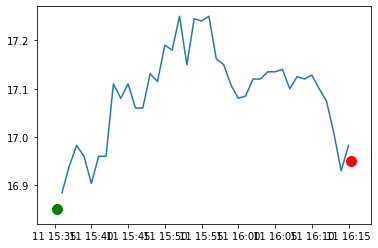

buy time:2020-02-11T15:35:15.484710377Z sell time:2020-02-11T16:15:22.47028254Z
{'rsi': 66.65001007395377, 'macd1': [0.007985575073366391, 0.005765985646558391, 0.003211424293400711, 0.009900455435015942, 0.019016927635028935], 'macd2': [0.07283352617131911, 0.07086224720521983, 0.06878493337482539, 0.06851342643470915, 0.0689537338417665], 'macd_signal': [0.021975681242691045, 0.018733742123464514, 0.015629278557451755, 0.014483513932964593, 0.015390196673377462]}
{'rsi': 34.73556621315997, 'macd': [0.010320822092833026, 0.006888171614932048, 0.0006849612215660272, -0.008209552867050718, -0.014514244976790991], 'too_close': 1, 'macd_signal': [0.019533714649210138, 0.01700460604235452, 0.013740677078196822, 0.009350631089147313, 0.004577655875959652], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.019091900852750643}
buy indicator analysis
slope:0.002619717491178264 error=0.0016058327827914577
SALT analysis for run 55


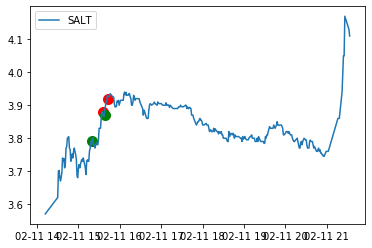

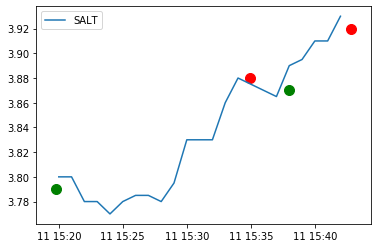

Delta = 0.13999999999999968


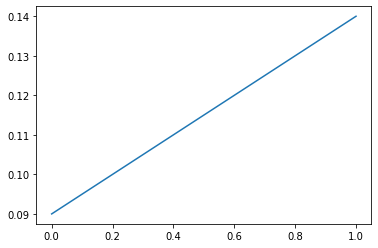

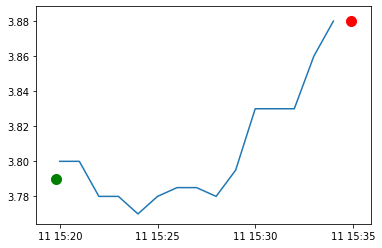

buy time:2020-02-11T15:19:48.481556222Z sell time:2020-02-11T15:34:54.917471257Z
{'rsi': 65.53030377948856, 'macd1': [0.004074613734112553, 0.004250467069474517, 0.006732967921174282, 0.009398939039501286, 0.012975994029193583], 'macd2': [0.02004958036508997, 0.01975876364949647, 0.019939409664219365, 0.020233655502372105, 0.020791882232312542], 'macd_signal': [0.006111151082924374, 0.005739014280234403, 0.005937805008422379, 0.0066300318146381605, 0.007899224257549246]}
{'rsi': 78.41647698685418, 'macd': [0.011413940659368738, 0.012723332905434148, 0.01357840046203762, 0.015626785565078904, 0.01852647804062979], 'too_close': 0, 'macd_signal': [0.009868367771582787, 0.010439360798353059, 0.011067168731089972, 0.011979092097887759, 0.013288569286436165], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005237908754193625}
buy indicator analysis
slope:0.002295123256018883 error=0.0003557502747417334


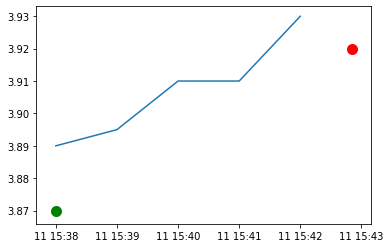

buy time:2020-02-11T15:37:59.855329344Z sell time:2020-02-11T15:42:50.72033335Z
{'rsi': 72.85439305721701, 'macd1': [0.02276154607830394, 0.02595631462854131, 0.029758981559598663, 0.032000284920858935, 0.03299275581733507], 'macd2': [0.02383566656401559, 0.02469146711472625, 0.02575921249606461, 0.026620406127601637, 0.02729018818344242], 'macd_signal': [0.018839431385063117, 0.020262808033758756, 0.02216204273892674, 0.02412969117531318, 0.025902304103717556]}
{'rsi': 78.8701418075527, 'macd': [0.02107000598090769, 0.022061869325971983, 0.023327452850359975, 0.02401066789728068, 0.02475069692218934], 'too_close': 0, 'macd_signal': [0.016625420832642176, 0.017712710531308136, 0.018835658995118503, 0.019870660775550938, 0.020846668004878617], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0039040289173107243}
buy indicator analysis
slope:0.002650638977037989 error=0.00031491099984677157
DAC analysis for run 55


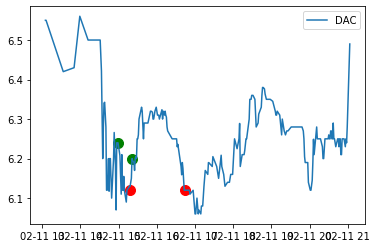

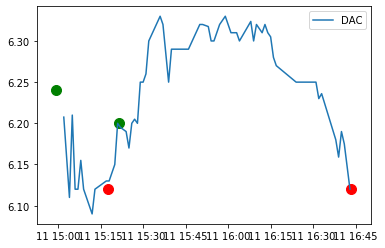

Delta = -0.20000000000000018


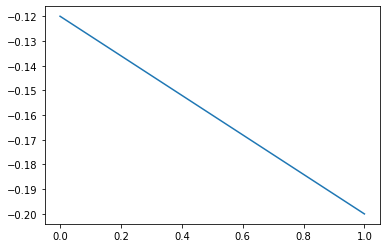

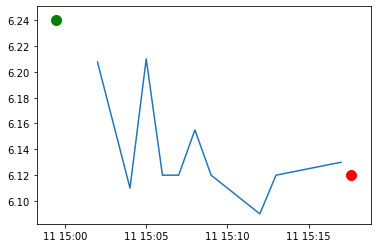

buy time:2020-02-11T14:59:25.659567419Z sell time:2020-02-11T15:17:38.631434963Z
{'rsi': 47.38423763063595, 'macd1': [0.07416649744993364, 0.06831921091633042, 0.05418450823710952, 0.05605407726920664, 0.0568800464280379], 'macd2': [0.062125566788445497, 0.06229446092116131, 0.060590921359263916, 0.06164561619438391, 0.06251737563094295], 'macd_signal': [0.09086525946423288, 0.08635604975465239, 0.07992174145114381, 0.07514820861475638, 0.07149457617741269]}
{'rsi': 43.91283659100039, 'macd': [0.007602822861167091, 0.004443030774180734, 0.0008841923846567568, -0.00034196989788970455, -0.0015527201193821227], 'too_close': 0, 'macd_signal': [0.019822694855869256, 0.01674676203953155, 0.013574248108556591, 0.010791004507267332, 0.008322259581937441], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009874979701319564}
buy indicator analysis
slope:-0.004683803569091527 error=0.0017435065427832957


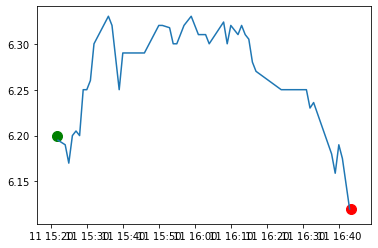

buy time:2020-02-11T15:21:36.499609995Z sell time:2020-02-11T16:43:27.49672379Z
{'rsi': 50.74558332824546, 'macd1': [0.005494439645598703, 0.004595702497661058, 0.004636911826227497, 0.005414076834918902, 0.009949871906288266], 'macd2': [0.05050963816219145, 0.04940915618545905, 0.04847759055043266, 0.047702923261987884, 0.04771359054557145], 'macd_signal': [0.02094159755714146, 0.01767241854524538, 0.015065317201441802, 0.013135069128137222, 0.01249802968376743]}
{'rsi': 27.50787239069074, 'macd': [-0.0105811178571793, -0.01450145816115711, -0.015757548551775358, -0.0173108975762597, -0.021153625419023214], 'too_close': 1, 'macd_signal': [-0.0019018131908998114, -0.0044217421849512715, -0.006688903458316089, -0.00881330228190481, -0.011281366909328492], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009872258509694722}
buy indicator analysis
slope:0.0009729238858636968 error=0.0005933796135260086
SID analysis for run 55


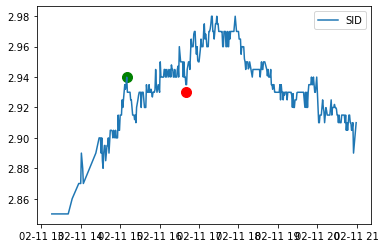

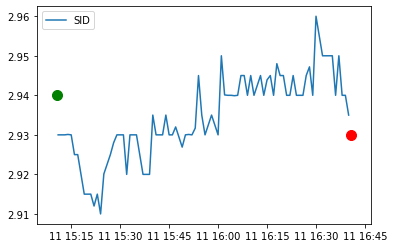

Delta = -0.009999999999999787


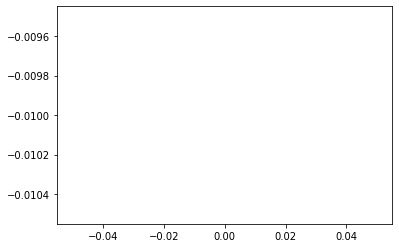

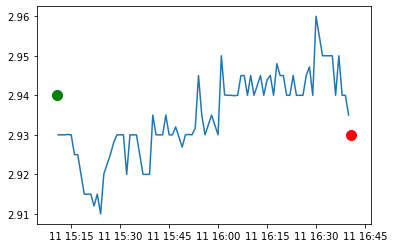

buy time:2020-02-11T15:10:31.004291773Z sell time:2020-02-11T16:40:48.371026786Z
{'rsi': 70.98371821759861, 'macd1': [0.013931992496441392, 0.014535857943460684, 0.014604004855587771, 0.014730285144512578, 0.015060216594302123], 'macd2': [0.01763015157665393, 0.017843693141028627, 0.017963638909546553, 0.018093243330866482, 0.01826351394267478], 'macd_signal': [0.014554644032017217, 0.01455088681430591, 0.014561510422562282, 0.014595265366952341, 0.014688255612422298]}
{'rsi': 43.02153191898713, 'macd': [0.001226383533492914, 0.0012754185034937748, 0.0007775831748779716, 0.00037956105939951357, -0.00019525566771871894], 'too_close': 1, 'macd_signal': [0.0015293986464790326, 0.0014786026178819811, 0.0013383987292811793, 0.001146631195304846, 0.000878253822700133], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001073509490418852}
buy indicator analysis
slope:0.00024508753967733554 error=4.988976561570522e-05
ASNA analysis for run 55


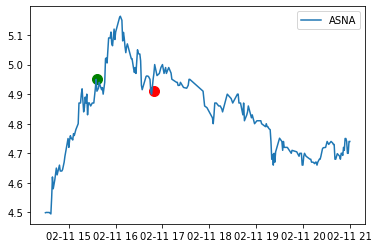

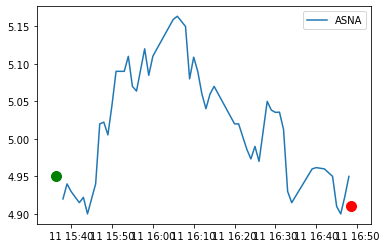

Delta = -0.040000000000000036


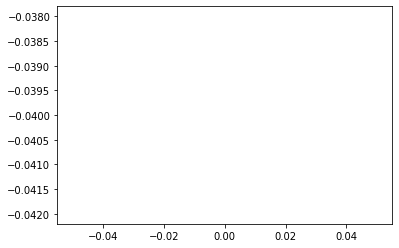

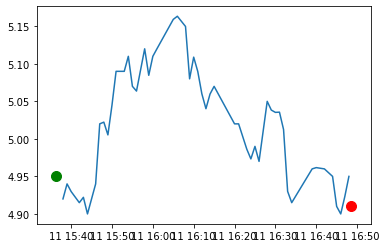

buy time:2020-02-11T15:36:24.777554445Z sell time:2020-02-11T16:48:34.761013186Z
{'rsi': 69.0898382405226, 'macd1': [0.051292945253564426, 0.04867857352099847, 0.0460755350009423, 0.0474996440236799, 0.050467254864586586], 'macd2': [0.059353718954968215, 0.059305120999590955, 0.05916555907263277, 0.059742210719885946, 0.060657007440177324], 'macd_signal': [0.06065366707801575, 0.05825864836661229, 0.05582202569347829, 0.054157549359518616, 0.05341949046053221]}
{'rsi': 38.464687822091015, 'macd': [-0.015595275425918764, -0.017843662621958245, -0.019883397286118765, -0.02000938017655418, -0.020533400868107066], 'too_close': 0, 'macd_signal': [-0.011165007269102797, -0.012500738339673887, -0.013977270128962863, -0.015183692138481126, -0.016253633884406316], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00427976698370075}
buy indicator analysis
slope:-0.00028303102752742505 error=0.0007598638002081699
ASC analysis for run 55


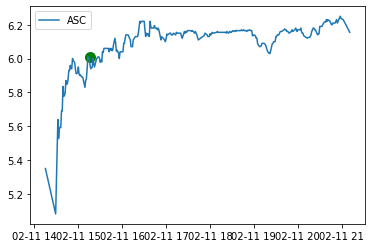

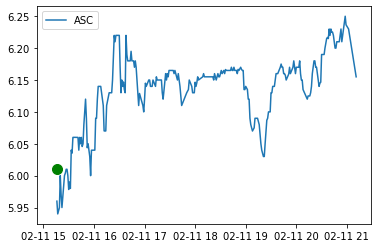

Delta = nan


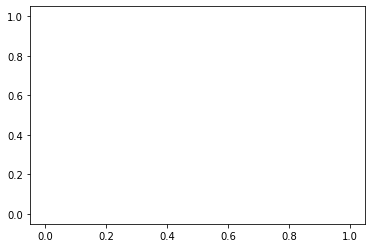

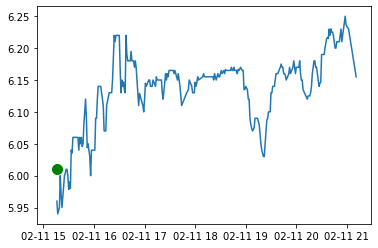

buy time:2020-02-11T15:15:46.858617468Z sell time:None
{'rsi': 67.49640015734842, 'macd1': [0.0425378749486649, 0.04361988237294767, 0.04955456189484497, 0.053639515230863744, 0.05622870071941488], 'macd2': [0.08370169742828981, 0.08359042717839227, 0.08447391596138765, 0.08515164967823097, 0.08563899821231491], 'macd_signal': [0.06781136495214876, 0.06297306843630854, 0.060289367128015824, 0.058959396748585406, 0.0584132575427513]}
None
buy indicator analysis
slope:0.0037401284399416037 error=0.00040159966529485413
LAIX analysis for run 55


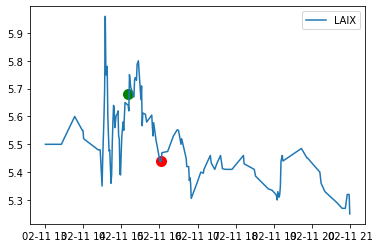

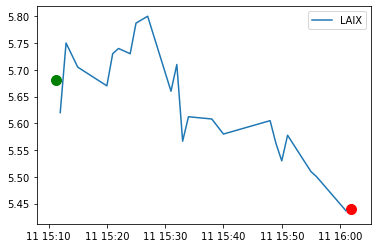

Delta = -0.23999999999999932


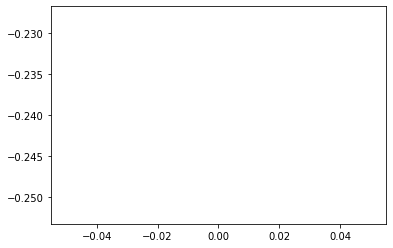

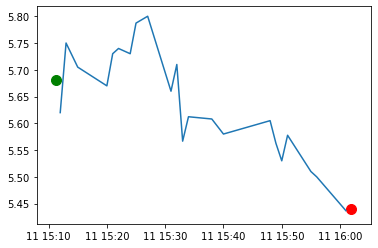

buy time:2020-02-11T15:11:21.522782225Z sell time:2020-02-11T16:01:56.015055017Z
{'rsi': 60.85869598396253, 'macd1': [0.017663522306261115, 0.01866777509542228, 0.023230448647097113, 0.03052906241382658, 0.03988804399842927], 'macd2': [0.06108687632617826, 0.06054259765303005, 0.060744694567254065, 0.061633157670556216, 0.06315167865017113], 'macd_signal': [0.032672688535089846, 0.029871705847156333, 0.028543454407144488, 0.028940576008480906, 0.03113006960647058]}
{'rsi': 37.965138900373596, 'macd': [-0.004324997837036548, -0.00591837796430017, -0.010599993934060414, -0.014629824638626054, -0.020857876815708387], 'too_close': 1, 'macd_signal': [0.011615747333809854, 0.008108922274187849, 0.004367139032538195, 0.0005677462983053453, -0.003717378324497402], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.017140498491210986}
buy indicator analysis
slope:0.0056310330702740614 error=0.0009527774435414911
IMMP analysis for run 55


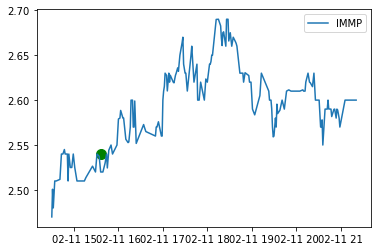

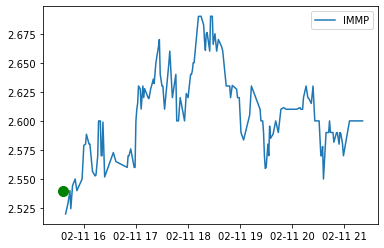

Delta = nan


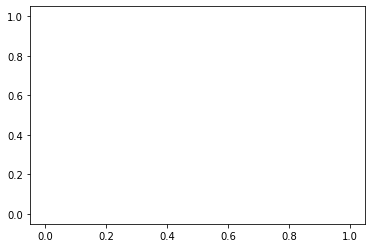

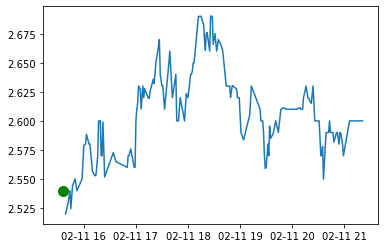

buy time:2020-02-11T15:36:03.921906609Z sell time:None
{'rsi': 64.0427495637322, 'macd1': [0.024279998858689922, 0.023152264919461096, 0.021486350694487122, 0.02153173013994092, 0.022087719960282914], 'macd2': [0.0160766318572243, 0.016406495092327056, 0.016579781507202185, 0.01703256555942101, 0.01757543874691292], 'macd_signal': [0.031725482812633446, 0.030010839233998977, 0.028305941526096605, 0.02695109924886547, 0.025978423391148957]}
None
buy indicator analysis
slope:-0.0006005092576334193 error=0.0002659854796999185
TNK analysis for run 55


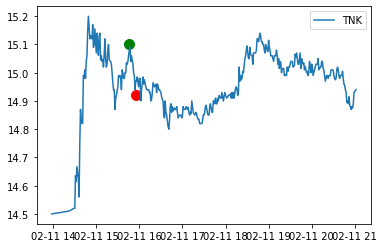

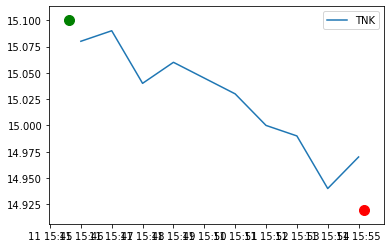

Delta = -0.17999999999999972


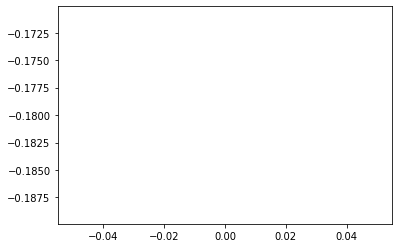

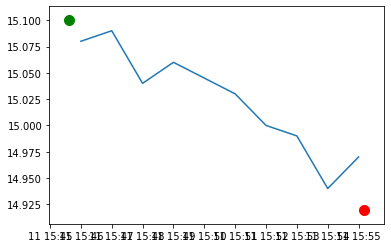

buy time:2020-02-11T15:45:36.900566377Z sell time:2020-02-11T15:55:10.423754223Z
{'rsi': 64.63467337241148, 'macd1': [-0.002840055553045673, 0.0013859862366363274, 0.004282332525001209, 0.0073004689899587305, 0.014368234379997347], 'macd2': [0.04902063087714126, 0.048390406890344906, 0.04765321895704666, 0.04705870383895494, 0.047396083246358245], 'macd_signal': [-0.008566793760653372, -0.006576237761195432, -0.004404523703956104, -0.002063525165173137, 0.0012228267438609596]}
{'rsi': 36.86751951467642, 'macd': [0.010859988506403795, 0.008035939407907478, 0.005211538299885632, 0.00034562135467552935, -0.004489451866977134], 'too_close': 1, 'macd_signal': [0.007695766048661194, 0.00776380072051045, 0.0072533482363854864, 0.005871802860043495, 0.0037995519146393694], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.008289003781616504}
buy indicator analysis
slope:0.004033106261940845 error=0.00042381271051953175
GOGL analysis for run 55

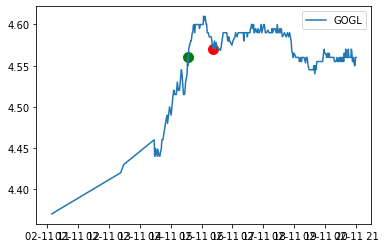

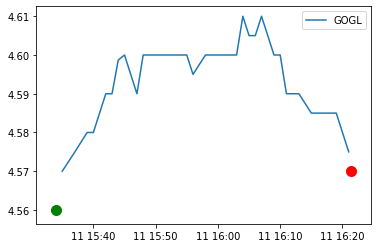

Delta = 0.010000000000000675


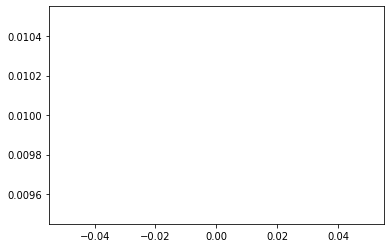

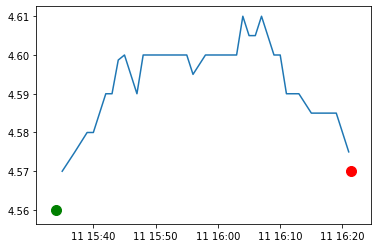

buy time:2020-02-11T15:34:03.862292378Z sell time:2020-02-11T16:21:23.413350374Z
{'rsi': 72.50185663007332, 'macd1': [0.025215493130857247, 0.02415120808897875, 0.023839859887063497, 0.024919688391122463, 0.02548172282147032], 'macd2': [0.02613939927807163, 0.026248139627385925, 0.026466140021332407, 0.026944250515689383, 0.02734103390051601], 'macd_signal': [0.03093901975971337, 0.029581457425566445, 0.028433137917865857, 0.02773044801251718, 0.02728070297430781]}
{'rsi': 39.90128042357649, 'macd': [0.0031229742672183036, 0.0023239683631572916, 0.0016711849526798161, 0.000881078594480833, -5.771536511822717e-06], 'too_close': 1, 'macd_signal': [0.00636443907035731, 0.005556344928917306, 0.004779312933669808, 0.003999666065832013, 0.003198578545363246], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0032043500818750687}
buy indicator analysis
slope:0.00013009396833698616 error=0.00024457611575372083
INFU analysis for run 55


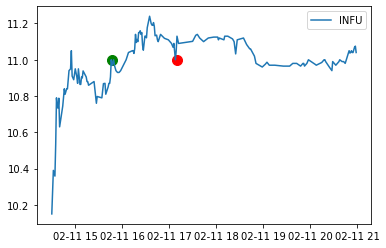

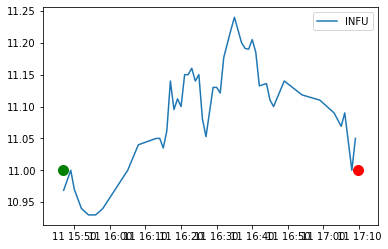

Delta = 0.0


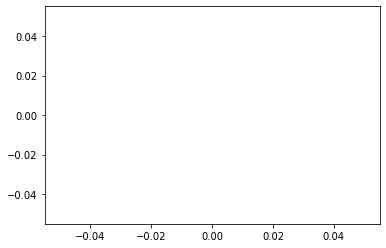

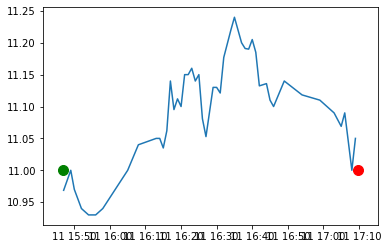

buy time:2020-02-11T15:46:48.452404035Z sell time:2020-02-11T17:09:37.493162567Z
{'rsi': 65.75803812237609, 'macd1': [0.0408363023400824, 0.03984047666338597, 0.038606248835051815, 0.03999132676060135, 0.048199107736339286], 'macd2': [0.115516646373095, 0.1141346041010749, 0.11268053865352634, 0.11172231124471921, 0.1121814193964017], 'macd_signal': [0.06528118456742175, 0.0601930429866146, 0.05587568415630204, 0.05269881267716191, 0.05179887168899738]}
{'rsi': 35.97705240988784, 'macd': [0.0051624290711860255, 0.0022403381594457983, -0.0011618149946297507, -0.0027016510238500047, -0.008541761552804061], 'too_close': 1, 'macd_signal': [0.014889648304170383, 0.012359786275225467, 0.009655466021254423, 0.007184042612233538, 0.004038881779226018], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.01258064333203008}
buy indicator analysis
slope:0.001487646088972916 error=0.00110440629283569
ATOM analysis for run 55


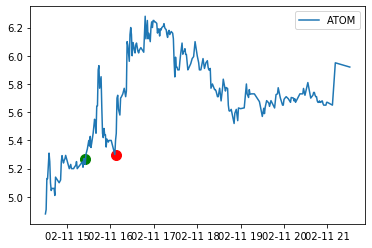

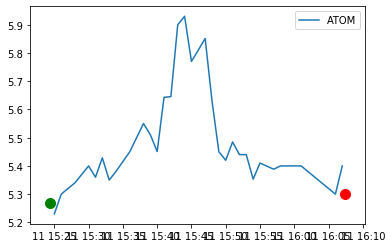

Delta = 0.03000000000000025


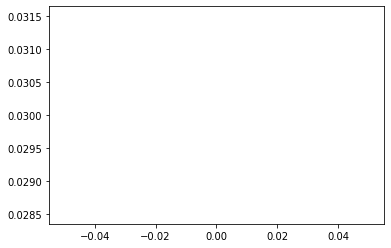

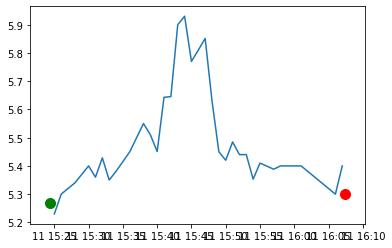

buy time:2020-02-11T15:24:23.214599407Z sell time:2020-02-11T16:07:23.193938552Z
{'rsi': 60.009790897206095, 'macd1': [0.04391429346603015, 0.043024028748775756, 0.03889263583641167, 0.039998893402662716, 0.04040979157106239], 'macd2': [0.05816444966599743, 0.058316722206178895, 0.057773384431742514, 0.05814071199803372, 0.058385677164784155], 'macd_signal': [0.0565203454521611, 0.05382108211148403, 0.050835392856469555, 0.04866809296570819, 0.04701643268677903]}
{'rsi': 40.5585181819922, 'macd': [0.001239224004662809, -0.004879729274246181, -0.008976579501003279, -0.012052351372489056, -0.019487337877901467], 'too_close': 1, 'macd_signal': [0.033721242275226763, 0.026001047965332175, 0.019005522472065085, 0.012793947703154257, 0.006337690586943112], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.02582502846484458}
buy indicator analysis
slope:-0.001003413913604856 error=0.0005165786523785902
QTT analysis for run 55


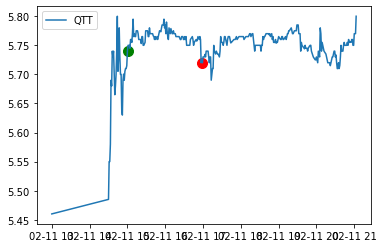

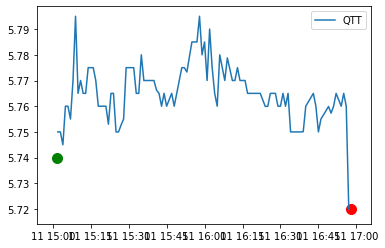

Delta = -0.020000000000000462


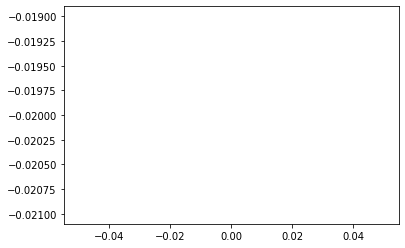

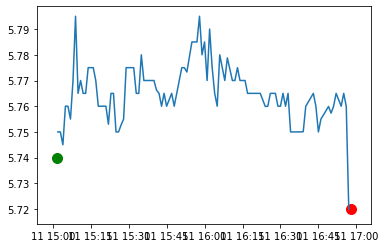

buy time:2020-02-11T15:01:30.307877404Z sell time:2020-02-11T16:57:59.376813707Z
{'rsi': 60.13385696047138, 'macd1': [0.02770403428338586, 0.02683078190581689, 0.026239706317626954, 0.027471886910154453, 0.028124200628970364], 'macd2': [0.03706790106791491, 0.037057754766757434, 0.03706911915778832, 0.03742012794912419, 0.03768321899953175], 'macd_signal': [0.037667768972053955, 0.035500371558806545, 0.033648238510570624, 0.03241296819048739, 0.031555214678183986]}
{'rsi': 29.521671799024453, 'macd': [-0.0007081849511010319, -0.0005781418371828551, -0.00020956094533541858, -0.0001793737446051935, -0.0022314437993005143], 'too_close': 1, 'macd_signal': [-0.001571983948397038, -0.0013732155261542015, -0.0011404846099904449, -0.0009482624369133946, -0.0012048987093908185], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0010265450899096958}
buy indicator analysis
slope:0.00014814376955065713 error=0.0002577899458221347
FRO analysis for 

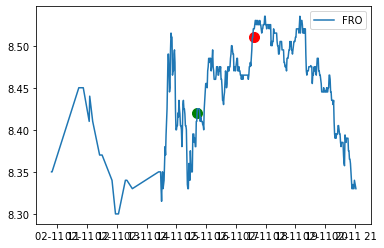

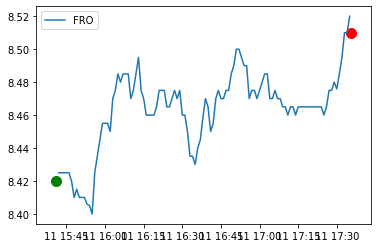

Delta = 0.08999999999999986


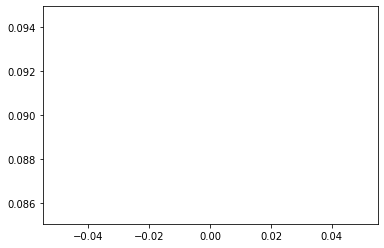

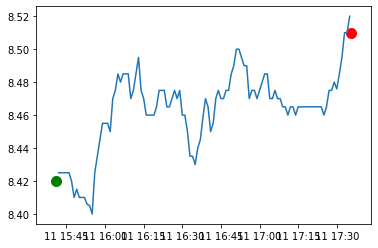

buy time:2020-02-11T15:41:07.550634571Z sell time:2020-02-11T17:35:34.317795755Z
{'rsi': 60.50241942804355, 'macd1': [-0.002688760584346639, -0.002310147101619364, -0.0019871861439089145, 0.0006816543345706805, 0.0035625788765756283], 'macd2': [0.01660025823911937, 0.01608700461082968, 0.015589065939444424, 0.015585821978381986, 0.015717846111801492], 'macd_signal': [-0.008142293176012241, -0.006975863961133666, -0.005978128397688716, -0.004646171851236837, -0.003004421705674344]}
{'rsi': 79.50086249392928, 'macd': [0.001480586323303612, 0.0025219424445435124, 0.004079857052722957, 0.005240831331139617, 0.0063371641282028435], 'too_close': 0, 'macd_signal': [-6.863540619216009e-05, 0.0004494801639549745, 0.001175555541708571, 0.00198861069959478, 0.002858321385316393], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0034788427428864505}
buy indicator analysis
slope:0.0015494480358034582 error=0.0003723927442097911
CNR analysis for run

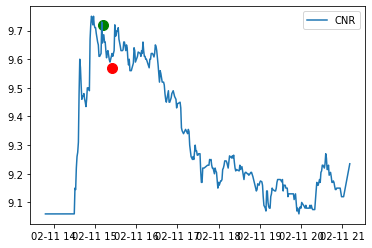

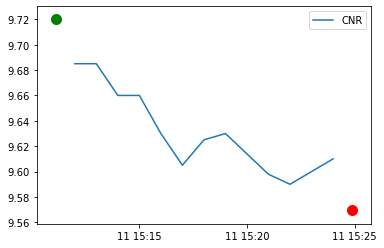

Delta = -0.15000000000000036


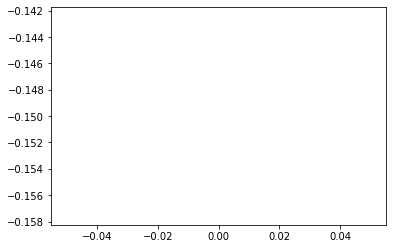

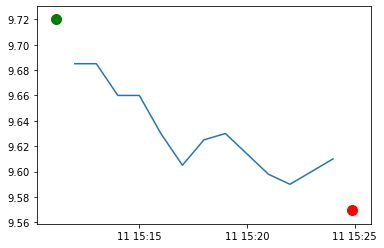

buy time:2020-02-11T15:11:07.662096464Z sell time:2020-02-11T15:24:51.596337569Z
{'rsi': 69.30121995255274, 'macd1': [0.09700744489772006, 0.08678680516559645, 0.07858787882087626, 0.08004355899158355, 0.08027187184337592], 'macd2': [0.11318510520226077, 0.11204810614275296, 0.11098276137645868, 0.11158440497791844, 0.1119594726736608], 'macd_signal': [0.12002912308321916, 0.11338065949969461, 0.10642210336393094, 0.10114639448946147, 0.09697148996024436]}
{'rsi': 45.27793123868257, 'macd': [0.01736081278581736, 0.015010100532302673, 0.01131590786031289, 0.007879966715123032, 0.004061311709582682], 'too_close': 1, 'macd_signal': [0.03113198238447807, 0.02790760601404299, 0.02458926638329697, 0.021247406449662182, 0.01781018750164628], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0137488757920636}
buy indicator analysis
slope:-0.004021439228270119 error=0.001555937296365709
YRCW analysis for run 55


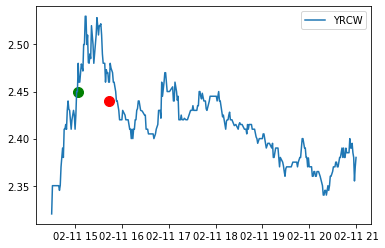

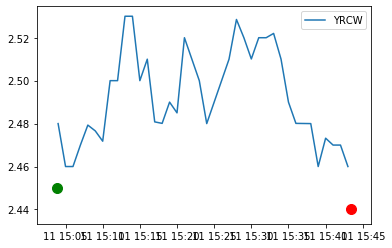

Delta = -0.010000000000000231


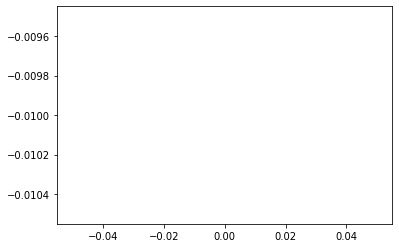

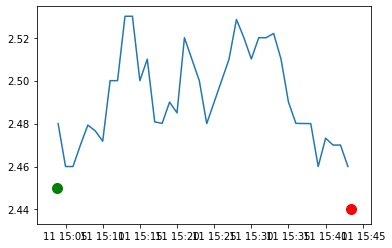

buy time:2020-02-11T15:03:47.42154694Z sell time:2020-02-11T15:43:27.244537379Z
{'rsi': 68.41800013194018, 'macd1': [0.022402928635993913, 0.02013541608813174, 0.01932599268353119, 0.02046589180888958, 0.021125745632929238], 'macd2': [0.020166239116937934, 0.020050845997450217, 0.020152516148617128, 0.02061366487042493, 0.021004967769024496], 'macd_signal': [0.024525306830803336, 0.023647328682269018, 0.022783061482521454, 0.022319627547795078, 0.02208085116482191]}
{'rsi': 35.426332099572335, 'macd': [7.523025101185965e-05, -0.0010361375030054631, -0.0020549157853175792, -0.002822081774322971, -0.004941664599855233], 'too_close': 1, 'macd_signal': [0.005103920924475859, 0.0038759092389795947, 0.00268974423412016, 0.0015873790324315337, 0.0002815703059741801], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005223234905829413}
buy indicator analysis
slope:-0.00022238902853715105 error=0.00040198368891987684
UGP analysis for run 55


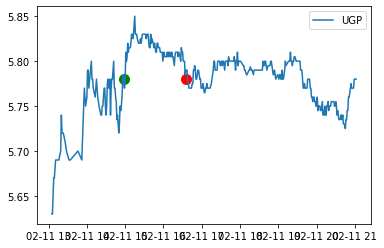

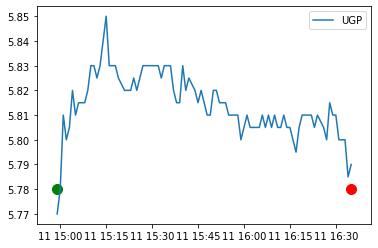

Delta = 0.0


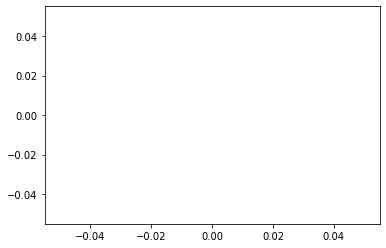

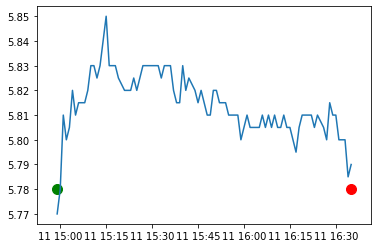

buy time:2020-02-11T14:58:49.385288341Z sell time:2020-02-11T16:35:01.699347703Z
{'rsi': 57.834215664867436, 'macd1': [0.022959059171771656, 0.022520438436358425, 0.02311672773554907, 0.024118188266418095, 0.024229096793265903], 'macd2': [0.03501888013821031, 0.03497882321904111, 0.0351259298708273, 0.03536502970540312, 0.035448479765594065], 'macd_signal': [0.03285523201486625, 0.030788273299164687, 0.029253964186441564, 0.02822680900243687, 0.027427266560602674]}
{'rsi': 31.766596061251462, 'macd': [-0.00034632888599794853, -0.0006693767020964358, -0.0009124090691585707, -0.0018691562503869719, -0.0028501390377027036], 'too_close': 1, 'macd_signal': [-0.0004280750576799985, -0.000476335386563286, -0.0005635501230823429, -0.0008246713485432688, -0.0012297648863751557], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0016203741513275479}
buy indicator analysis
slope:0.0004137825073048163 error=0.0001340023089658851
WLL analysis for r

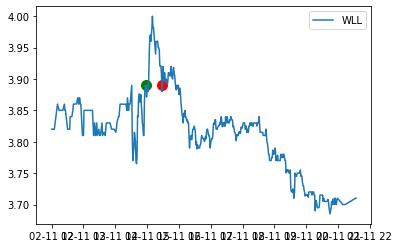

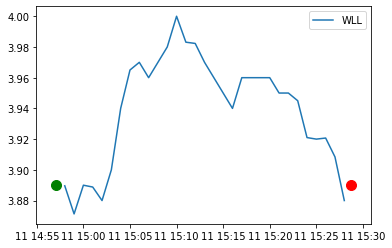

Delta = 0.0


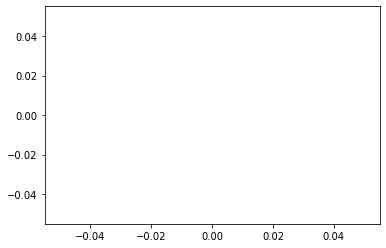

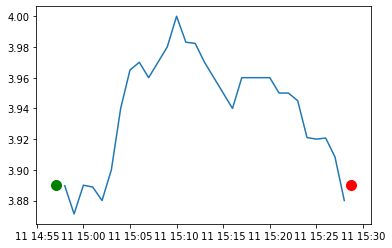

buy time:2020-02-11T14:57:05.235568889Z sell time:2020-02-11T15:28:44.630793742Z
{'rsi': 61.024653417481865, 'macd1': [0.03169795630411887, 0.027114177948488027, 0.023229859545090825, 0.02628767436242807, 0.028383823585556467], 'macd2': [0.021665282880261483, 0.02141814155109767, 0.02115970701906633, 0.022164386472772524, 0.023053274868249485], 'macd_signal': [0.03730465697031094, 0.035266561165946356, 0.03285922084177525, 0.031544911545905815, 0.030912693953835946]}
{'rsi': 35.64164489840805, 'macd': [0.006803988988931753, 0.004719322581811181, 0.0030699809323428973, 0.0011059487258435752, -0.0013946731068288365], 'too_close': 1, 'macd_signal': [0.012847193292526914, 0.011221619150383767, 0.009591291506775592, 0.007894222950589188, 0.006036443739105583], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0074311168459344195}
buy indicator analysis
slope:-0.000745476902318476 error=0.0010420427967467037
NOK analysis for run 55


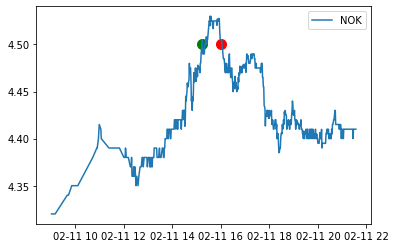

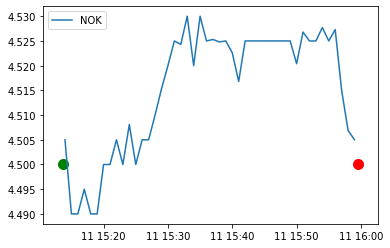

Delta = 0.0


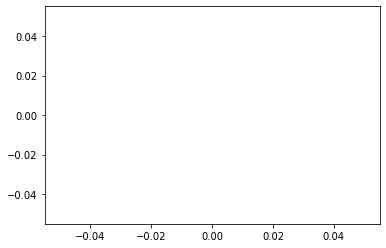

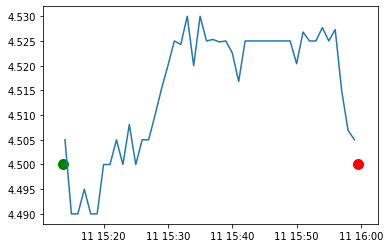

buy time:2020-02-11T15:13:39.630651349Z sell time:2020-02-11T15:59:28.309026134Z
{'rsi': 67.71477988312705, 'macd1': [0.01476655046171782, 0.01435623638211947, 0.014652927785487435, 0.015117253782022999, 0.015707625958430782], 'macd2': [0.027343787224115346, 0.027153175336747992, 0.027091115898851825, 0.027070658789617674, 0.027088509871783018], 'macd_signal': [0.017881611444737884, 0.0171765364322142, 0.016671814702868847, 0.016360902518699677, 0.016230247206645898]}
{'rsi': 33.01867605697118, 'macd': [0.002163719409460363, 0.0021073435574709976, 0.0013970851850446664, 0.00040471391841379045, -0.0007322599766030891], 'too_close': 1, 'macd_signal': [0.002890833379848119, 0.0027341354153726945, 0.0024667253693070887, 0.002054323079128429, 0.0014970064679821252], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0022292664445852143}
buy indicator analysis
slope:0.0002643168393329454 error=0.00011155468974470506
GASL analysis for run 55


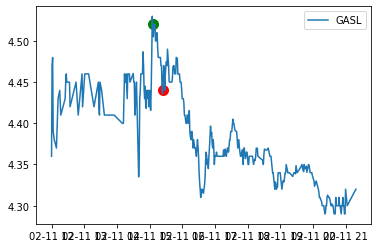

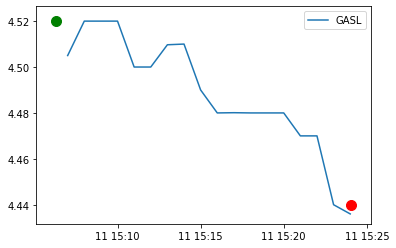

Delta = -0.07999999999999918


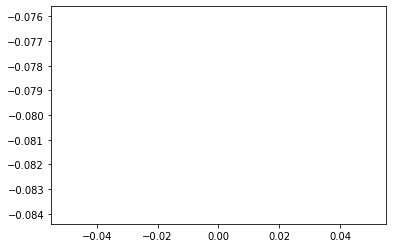

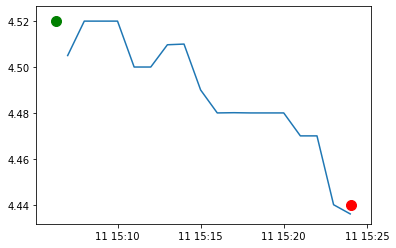

buy time:2020-02-11T15:06:19.00871855Z sell time:2020-02-11T15:24:03.273553292Z
{'rsi': 64.88957594883738, 'macd1': [0.016750461835880692, 0.016278920367533978, 0.01891484747504002, 0.02475308270200216, 0.028646251809144374], 'macd2': [0.029865680107428183, 0.02971861472322246, 0.030175523196652954, 0.03134731220288067, 0.03229529191280456], 'macd_signal': [0.02558059262939106, 0.023720258177019643, 0.022759176036623717, 0.023157957369699406, 0.0242556162575884]}
{'rsi': 41.917639050763, 'macd': [0.006399784083043869, 0.004948715885318755, 0.0037537443561124206, 0.0012154062248344033, -0.0003107716206409705], 'too_close': 1, 'macd_signal': [0.01081374109460818, 0.009640736052750296, 0.008463337713422722, 0.0070137514157050575, 0.005548846808435852], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005859618429076822}
buy indicator analysis
slope:0.0032265742280995547 error=0.0006611708122417589
VHC analysis for run 55


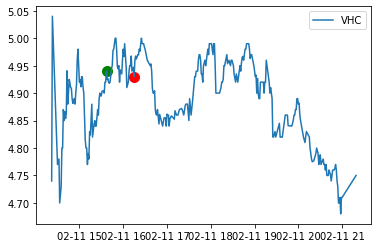

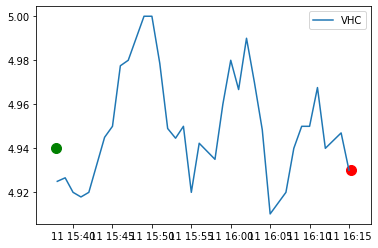

Delta = -0.010000000000000675


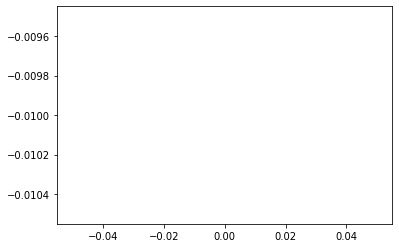

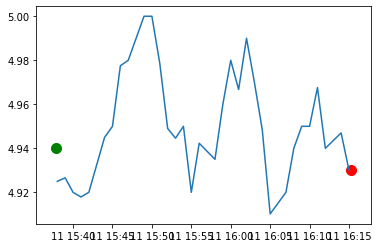

buy time:2020-02-11T15:37:53.69895456Z sell time:2020-02-11T16:15:16.326419455Z
{'rsi': 65.5283555492853, 'macd1': [0.013828345720179769, 0.014354462081992203, 0.016198519492733432, 0.017458695304651606, 0.01984249464100074], 'macd2': [0.024920152427021947, 0.02485404117995671, 0.025073338203460693, 0.025234997179177654, 0.025663240807489274], 'macd_signal': [0.00723199567137797, 0.008656488953500817, 0.01016489506134734, 0.011623655110008194, 0.013267423016206703]}
{'rsi': 46.64324493406329, 'macd': [0.0010913781558272717, 0.0020190295190776197, 0.001281887340843113, 0.0010544793144156017, -1.953316480562961e-05], 'too_close': 1, 'macd_signal': [0.003777541105377135, 0.003425838788117232, 0.0029970484986624082, 0.002608534661813047, 0.002082921096489312], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0021024542612949415}
buy indicator analysis
slope:0.0015132531064301347 error=0.00017227128832462878
BCLI analysis for run 55


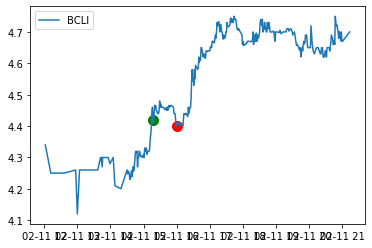

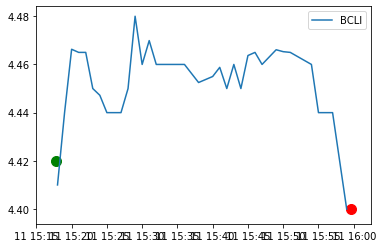

Delta = -0.019999999999999574


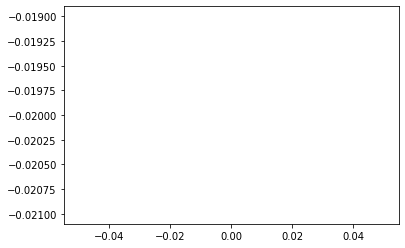

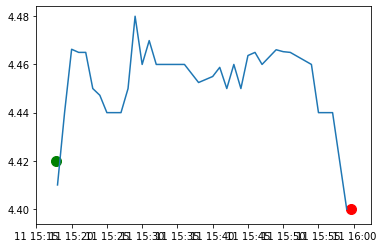

buy time:2020-02-11T15:17:49.624224687Z sell time:2020-02-11T15:59:37.162815524Z
{'rsi': 68.87692120223772, 'macd1': [0.027029694548809324, 0.030460355233716818, 0.03599992864515489, 0.041517259054171696, 0.04297366026859528], 'macd2': [0.033708516748296447, 0.0345803818486381, 0.035968562603732046, 0.03750647930387441, 0.03838161741255686], 'macd_signal': [0.02733862902053546, 0.02796297426317173, 0.02957036513956836, 0.03195974392248903, 0.03416252719171028]}
{'rsi': 32.98947470199053, 'macd': [0.006310749686129213, 0.0057212859013278106, 0.004148700018348883, 0.0028694292002047206, -0.0002425925957538766], 'too_close': 1, 'macd_signal': [0.008198073420758076, 0.007702715916872023, 0.006991912737167395, 0.00616741602977486, 0.004885414304669112], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.005128006900422989}
buy indicator analysis
slope:0.00429448352600268 error=0.0004076308261189279
NNA analysis for run 55


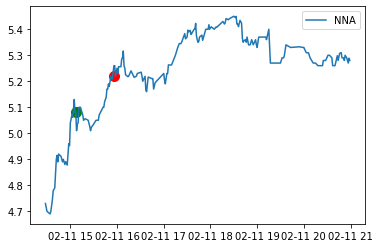

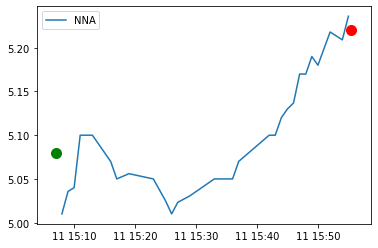

Delta = 0.13999999999999968


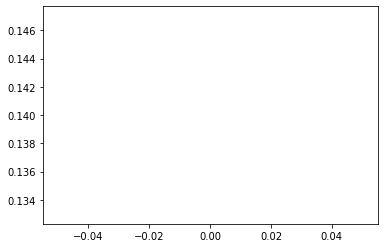

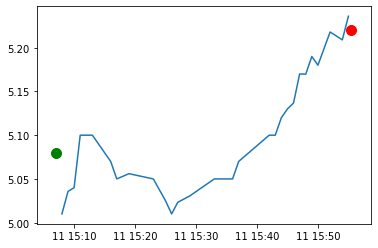

buy time:2020-02-11T15:07:06.70714648Z sell time:2020-02-11T15:55:28.360408232Z
{'rsi': 74.0520650395864, 'macd1': [0.08158733746077207, 0.08562005433622044, 0.09008534471628682, 0.09574806117113965, 0.09590263319507031], 'macd2': [0.04523837953274956, 0.04787198818876348, 0.05067584487198307, 0.05381417787821974, 0.05597573227079877], 'macd_signal': [0.06792886254402557, 0.07146710090246454, 0.075190749665229, 0.07930221196641113, 0.08262229621214297]}
{'rsi': 78.7129224500228, 'macd': [0.025223386073909282, 0.027165371665453186, 0.02780632963723484, 0.02991868221736027, 0.031654039004244794], 'too_close': 0, 'macd_signal': [0.02126720430163705, 0.022446837774400277, 0.02351873614696719, 0.024798725361045805, 0.026169788089685602], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005484250914559192}
buy indicator analysis
slope:0.0038758598303515693 error=0.0004966293954679329
DEACU analysis for run 55


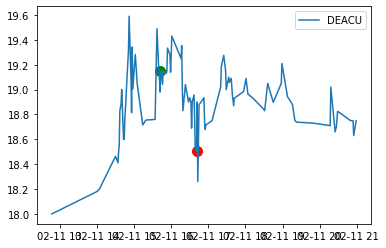

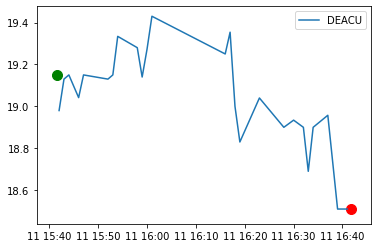

Delta = -0.639999999999997


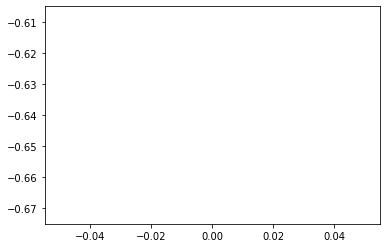

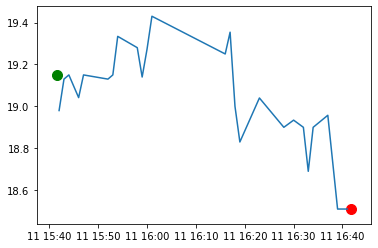

buy time:2020-02-11T15:41:28.522016807Z sell time:2020-02-11T16:41:48.459694161Z
{'rsi': 57.50823030136758, 'macd1': [0.3273370055610556, 0.2895245225953218, 0.25699879351851607, 0.286820529500865, 0.2869735074984199], 'macd2': [0.31990233632403076, 0.31634300365867674, 0.31264232533895964, 0.3204128850690573, 0.32305119230563406], 'macd_signal': [0.36277531953241793, 0.3481251601449987, 0.32989988681970217, 0.32128401535593476, 0.3144219137844318]}
{'rsi': 40.47119544366202, 'macd': [0.0015761699168983512, -0.017097171952315193, -0.020516695851021893, -0.019927796345456272, -0.042456864310658204], 'too_close': 1, 'macd_signal': [0.043796975732260046, 0.031618146195345, 0.021191177786071616, 0.012967382959766039, 0.00188253350568119], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.044339397816339395}
buy indicator analysis
slope:-0.008343098921972825 error=0.0077576907623232464
SWIR analysis for run 55


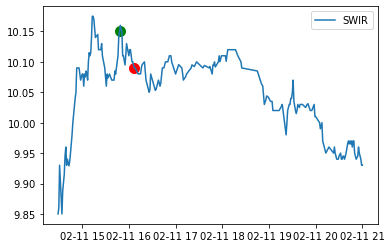

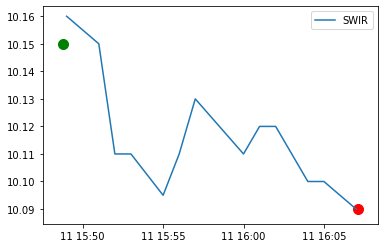

Delta = -0.0600000000000005


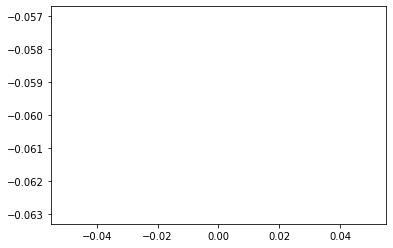

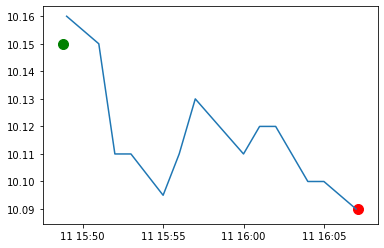

buy time:2020-02-11T15:48:45.669337531Z sell time:2020-02-11T16:07:05.39493452Z
{'rsi': 64.82284190747963, 'macd1': [0.002352390612601951, 0.0014903853046099869, 0.003191202965815876, 0.006880547823275407, 0.010490370172302477], 'macd2': [0.03909908181807964, 0.038095964044430275, 0.03759194251170683, 0.037547911597334505, 0.037607285135775825], 'macd_signal': [0.012634617060254793, 0.010405770709125833, 0.008962857160463841, 0.008546395293026154, 0.008935190268881418]}
{'rsi': 44.75904761267754, 'macd': [0.0033325816296621014, 0.0031826779187014154, 0.0019855753138138255, 0.0010269813968388775, -0.00025279284232126997], 'too_close': 1, 'macd_signal': [0.004583678052944823, 0.004303478026096141, 0.003839897483639678, 0.003277314266279518, 0.00257129284455936], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00282408568688063}
buy indicator analysis
slope:0.002166612163806647 error=0.0005557784332260425
TITN analysis for run 55


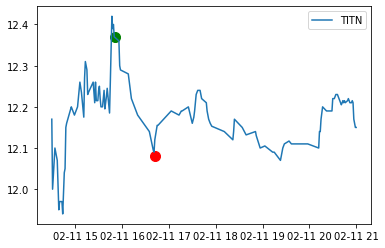

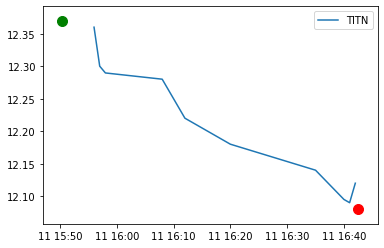

Delta = -0.28999999999999915


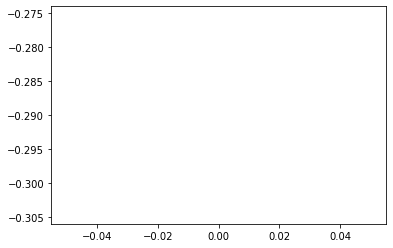

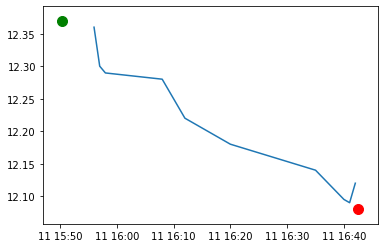

buy time:2020-02-11T15:50:26.426838983Z sell time:2020-02-11T16:42:24.816980933Z
{'rsi': 62.264068923000316, 'macd1': [0.04055870099861281, 0.0518289181185434, 0.05767505497184011, 0.06239581683727913, 0.06299019360550417], 'macd2': [0.08329627586268629, 0.08504083504732662, 0.08603006629229704, 0.08696253363716089, 0.08720154092463872], 'macd_signal': [0.044809752508471225, 0.04621358563048566, 0.04850587949875655, 0.05128386696646107, 0.05362513229426969]}
{'rsi': 34.52617791671906, 'macd': [0.016299226678871293, 0.00889099438220775, 0.0009249563019206875, -0.007632020855469435, -0.0149798988890808], 'too_close': 1, 'macd_signal': [0.0259298696682279, 0.02252209461102387, 0.018202666949203233, 0.013035729388268698, 0.007432603732798798], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.022412502621879597}
buy indicator analysis
slope:0.0055429883932518464 error=0.001110804962683944
FTI analysis for run 55


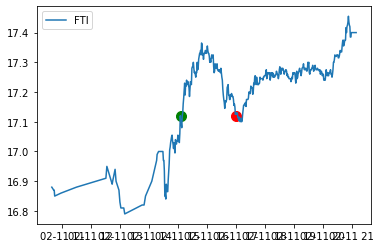

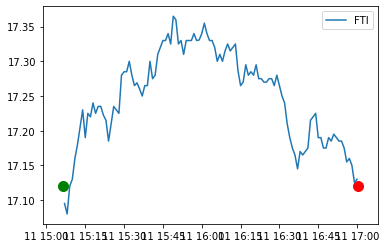

Delta = 0.0


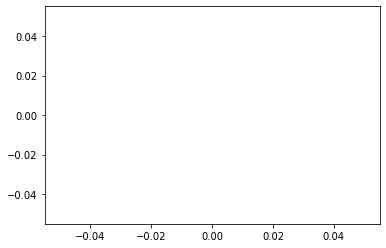

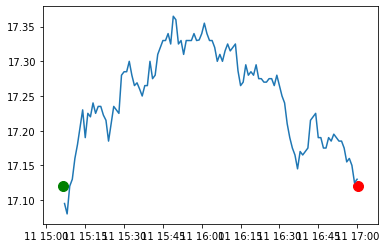

buy time:2020-02-11T15:06:23.71568853Z sell time:2020-02-11T17:00:12.401585694Z
{'rsi': 71.2033058369104, 'macd1': [0.08193025053482472, 0.0760835677937628, 0.07302894664001514, 0.0737920902188165, 0.07434678002877249], 'macd2': [0.1089870116773497, 0.108325486613019, 0.10802341899227486, 0.10837241888379623, 0.10868011943351874], 'macd_signal': [0.10232765094186501, 0.09707883431224457, 0.09226885677779868, 0.08857350346600225, 0.0857281587785563]}
{'rsi': 27.857334211520048, 'macd': [-0.009027736176889789, -0.009422480362765384, -0.010127183879514945, -0.011843482933091565, -0.013286787612074136], 'too_close': 1, 'macd_signal': [-0.009703834109347487, -0.009647563360031067, -0.009743487463927843, -0.010163486557760587, -0.010788146768623297], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0024986408434508386}
buy indicator analysis
slope:-0.0017458418587050772 error=0.0008365889628921401
SBLK analysis for run 55


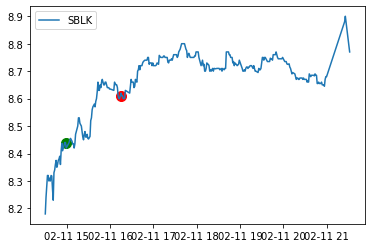

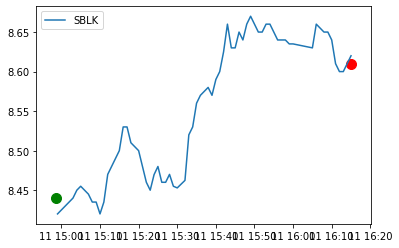

Delta = 0.16999999999999993


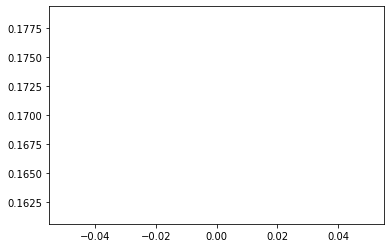

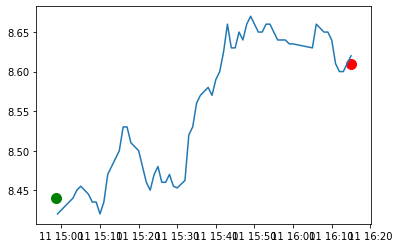

buy time:2020-02-11T14:58:43.937643657Z sell time:2020-02-11T16:15:01.463694471Z
{'rsi': 68.52634383035988, 'macd1': [0.05119413558186636, 0.05377858627620569, 0.05303673327289715, 0.054244264586284174, 0.054572167870716726], 'macd2': [0.033639664303606764, 0.03522676453221152, 0.036198779953199534, 0.03751497841936491, 0.0386659231442632], 'macd_signal': [0.05030308599149705, 0.050998186048438775, 0.05140589549333045, 0.051973569311921194, 0.0524932890236803]}
{'rsi': 43.865014709620226, 'macd': [0.007120697609934723, 0.0044957229654549735, 0.00239190216500873, 0.0012409781365452233, -0.00019144290039463385], 'too_close': 0, 'macd_signal': [0.012429804118756844, 0.01084298788809647, 0.009152770743478922, 0.007570412222092182, 0.006018041197594819], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.006209484097989453}
buy indicator analysis
slope:0.0007221742887779215 error=0.00025861607731732277
EGLE analysis for run 55


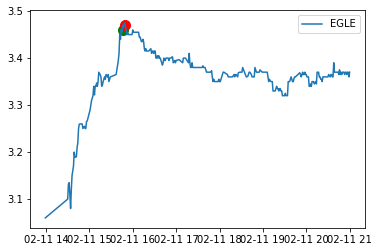

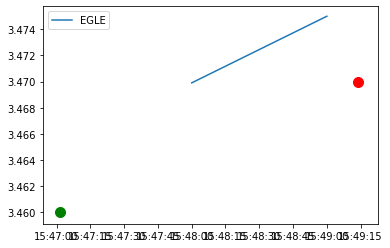

Delta = 0.010000000000000231


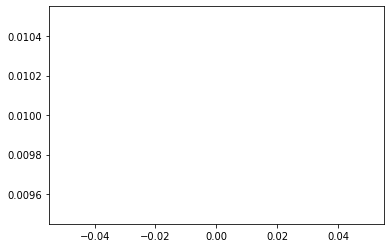

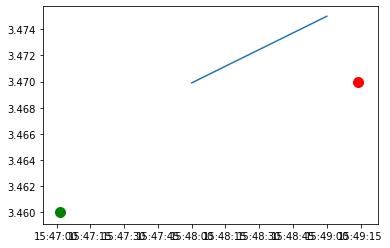

buy time:2020-02-11T15:47:01.6019521Z sell time:2020-02-11T15:49:13.772353502Z
{'rsi': 74.44109724678877, 'macd1': [0.032625394025727505, 0.03571037423578227, 0.037321565292255166, 0.03935515868074768, 0.039702217219530045], 'macd2': [0.04125610315095063, 0.04204586499783858, 0.042625256661052546, 0.04333004642131266, 0.043749239165284504], 'macd_signal': [0.0284124445284467, 0.029872030469913817, 0.031361937434382085, 0.032960581683655205, 0.03430890879083017]}
{'rsi': 78.18989797686953, 'macd': [0.021652818676830332, 0.022971610538572218, 0.023441167696571785, 0.023757171096356, 0.023959807887143914], 'too_close': 0, 'macd_signal': [0.017631859764936048, 0.01869980991966328, 0.01964808147504498, 0.020469899399307184, 0.02116788109687453], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002791926790269385}
buy indicator analysis
slope:0.001779843083257049 error=0.0002619016636565237
GLOG analysis for run 55


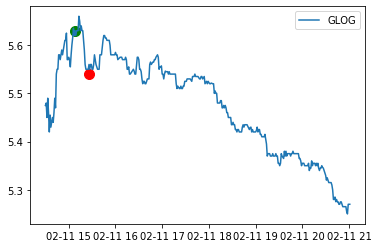

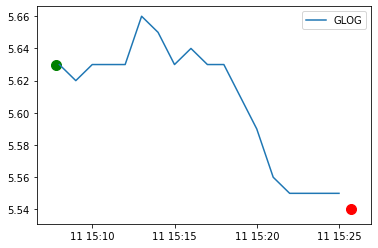

Delta = -0.08999999999999986


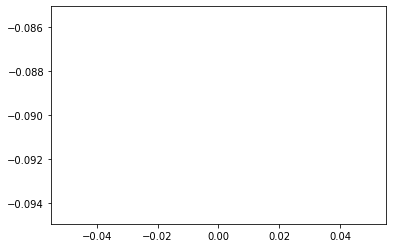

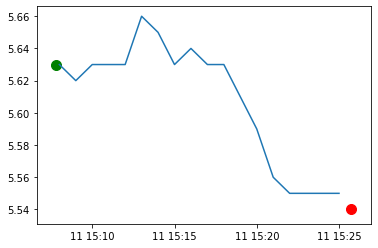

buy time:2020-02-11T15:07:49.178409807Z sell time:2020-02-11T15:25:45.346003552Z
{'rsi': 67.41483635852128, 'macd1': [0.028604597200772908, 0.027174580748773103, 0.02733995725220595, 0.028354540469970324, 0.030022894381666276], 'macd2': [0.02261784791113186, 0.02287551499240781, 0.023395862810899004, 0.024077085073636262, 0.024905227451190726], 'macd_signal': [0.03644664856020923, 0.03459223499792201, 0.033141779448778795, 0.0321843316530171, 0.031752044198746936]}
{'rsi': 35.60626005506292, 'macd': [0.004372965450093247, 0.0007851462302275181, -0.0020207537622685123, -0.004180925785481904, -0.006329359494668729], 'too_close': 0, 'macd_signal': [0.011648321569572222, 0.009475686501703282, 0.007176398448908923, 0.004904933602030757, 0.0026580749826908595], 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.008987434477359588}
buy indicator analysis
slope:0.00040165540829839586 error=0.0003482861234447092
TROX analysis for run 55


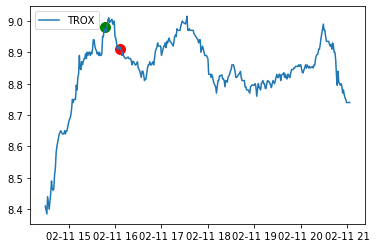

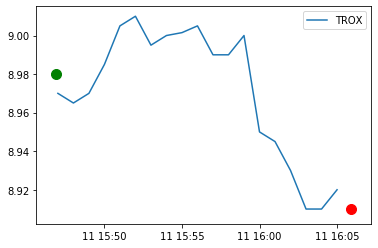

Delta = -0.07000000000000028


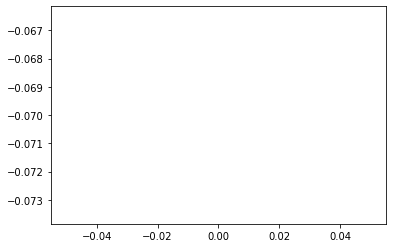

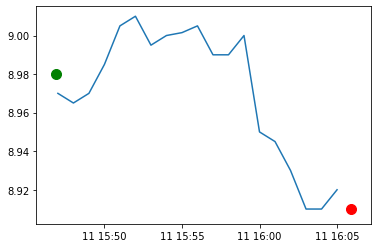

buy time:2020-02-11T15:46:53.654351446Z sell time:2020-02-11T16:05:55.284974225Z
{'rsi': 74.25571099052053, 'macd1': [0.023299937280579996, 0.021338630722494756, 0.02394628363883733, 0.025716424429262474, 0.029203384599204796], 'macd2': [0.06497514769733748, 0.06387215916360489, 0.06363486797897089, 0.06331477742008929, 0.06339882880526915], 'macd_signal': [0.03455767231258786, 0.03191386399456924, 0.030320347923422857, 0.02939956322459078, 0.029360327499513582]}
{'rsi': 38.68516745960214, 'macd': [0.010331396293505435, 0.00705779549410579, 0.0033763170076390736, 0.0004637841999031167, -0.0018117450554751002], 'too_close': 0, 'macd_signal': [0.015909561005852623, 0.014139207903503256, 0.011986629724330419, 0.009682060619444958, 0.0073832994844609465], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.009195044539936047}
buy indicator analysis
slope:0.0016184688344017318 error=0.000546084268107648
TNP analysis for run 55


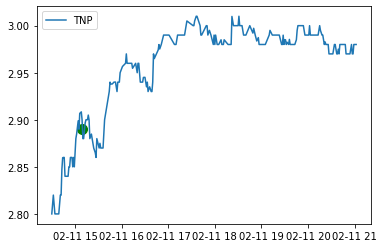

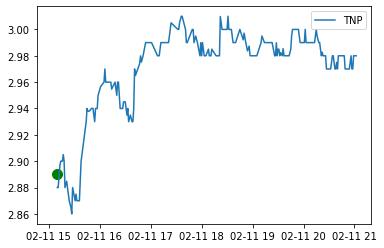

Delta = nan


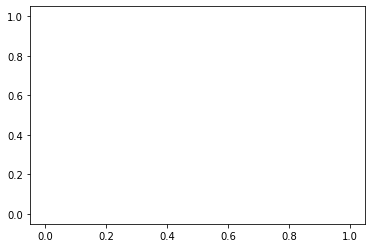

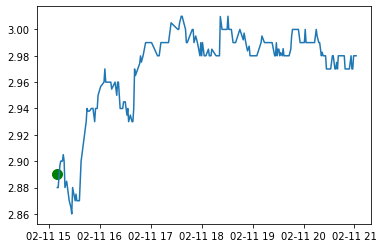

buy time:2020-02-11T15:09:15.742868091Z sell time:None
{'rsi': 72.34340285003623, 'macd1': [0.024078196904667948, 0.02561585636326802, 0.025818685211307812, 0.027023537611210457, 0.027787185074253706], 'macd2': [0.01764742924363727, 0.018425815826137892, 0.018970143800160155, 0.01970929537673971, 0.02038340597098287], 'macd_signal': [0.0243363358735328, 0.024592239971479843, 0.024837529019445435, 0.02527473073779844, 0.025777221605089492]}
None
buy indicator analysis
slope:0.0008825657587113956 error=0.0001008761030757699
LC analysis for run 55


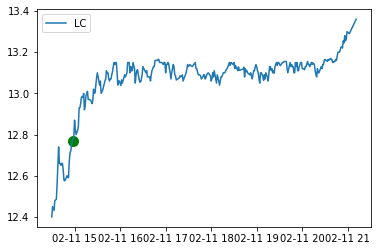

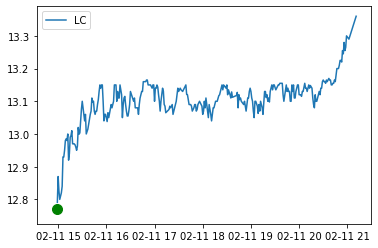

Delta = nan


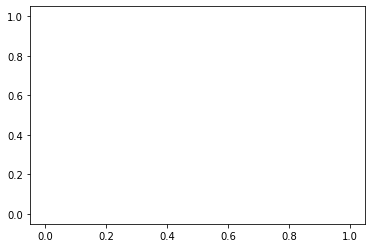

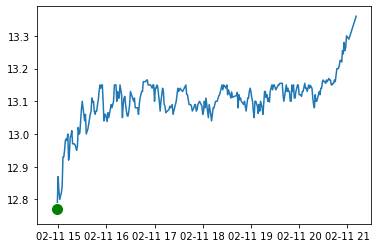

buy time:2020-02-11T14:58:12.24777546Z sell time:None
{'rsi': 71.63571934415984, 'macd1': [0.06113425409436779, 0.06288203144681148, 0.06672565152126708, 0.07215953446824841, 0.07719793809373776], 'macd2': [0.060901966619431036, 0.06205542321339408, 0.06365713530050066, 0.06566709570483198, 0.0677327696382779], 'macd_signal': [0.07599550193740165, 0.07337280783928361, 0.0720433765756803, 0.07206660815419393, 0.07309287414210269]}
None
buy indicator analysis
slope:0.004140487102017687 error=0.00042510838977550305
GPRE analysis for run 55


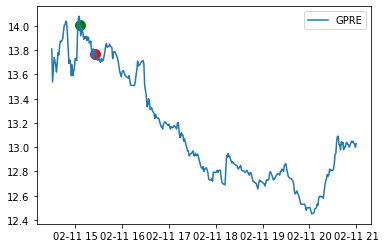

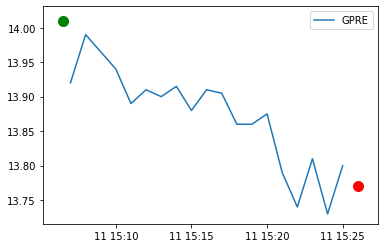

Delta = -0.2400000000000002


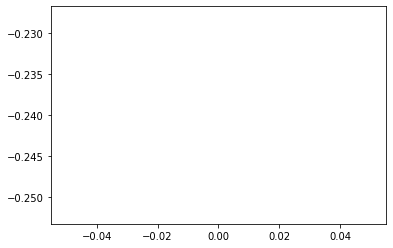

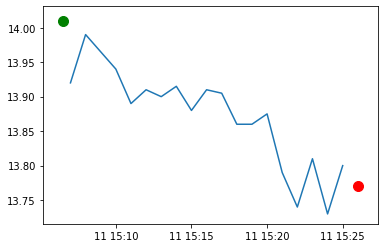

buy time:2020-02-11T15:06:28.442535634Z sell time:2020-02-11T15:25:59.621268187Z
{'rsi': 68.89978824898716, 'macd1': [0.08636394831043148, 0.07940393413101177, 0.09099476137926032, 0.10861156607371036, 0.11958072569387745], 'macd2': [0.17449052985343627, 0.17234685907186886, 0.17369752924193094, 0.17658161638481218, 0.1786327791398037], 'macd_signal': [0.14458631378708114, 0.13154983785586727, 0.12343882256054588, 0.12047337126317878, 0.12029484214931851]}
{'rsi': 45.35171083040757, 'macd': [0.011670959231860678, 0.0035953739863288092, 0.0008923806263521072, -0.005381281480465461, -0.008641521024992826], 'too_close': 0, 'macd_signal': [0.028459956500568002, 0.023487039997720165, 0.018968108123446552, 0.01409823020266415, 0.009550279957132753], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.01819180098212558}
buy indicator analysis
slope:0.009564118670959056 error=0.002508675575977171
DSSI analysis for run 55


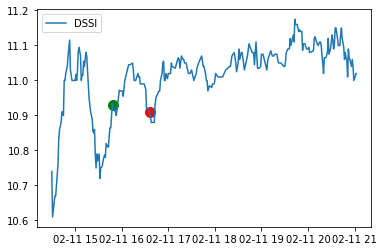

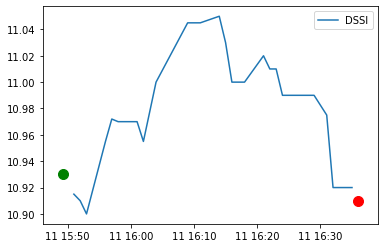

Delta = -0.019999999999999574


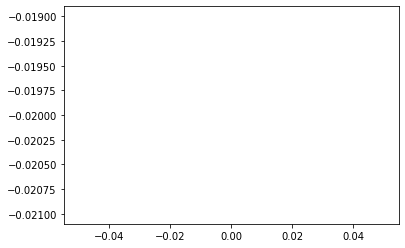

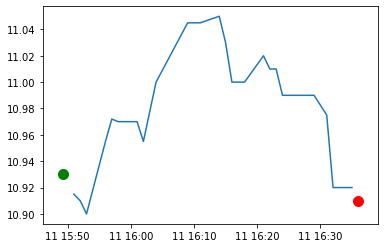

buy time:2020-02-11T15:49:13.211574735Z sell time:2020-02-11T16:35:52.854212986Z
{'rsi': 63.025592104100305, 'macd1': [-0.027876745368081046, -0.02125803463894549, -0.015830178259832905, -0.005813137754719477, 0.0021012174872332423], 'macd2': [0.024579077915769076, 0.024155295196184312, 0.02372676851943467, 0.02441411479801303, 0.025007448395699683], 'macd_signal': [-0.038404462495012316, -0.03497517692379895, -0.031146177191005743, -0.02607956930374849, -0.02044341194555214]}
{'rsi': 33.72673159244286, 'macd': [0.011142013419068064, 0.009059958050317007, 0.004462772593493369, 0.0008225920739750592, -0.0030635562798568827], 'too_close': 1, 'macd_signal': [0.017042547501338778, 0.015446029611134424, 0.013249378207606213, 0.010764020980879982, 0.00799850552873261], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.011062061808589492}
buy indicator analysis
slope:0.007540082259485459 error=0.00044676856078559716
HBM analysis for run 55


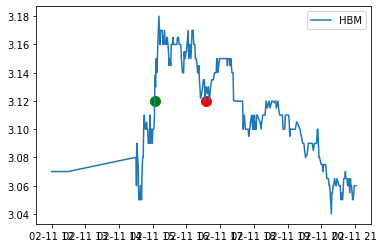

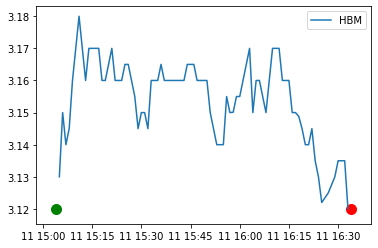

Delta = 0.0


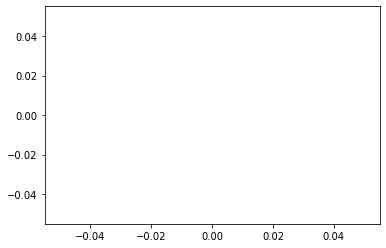

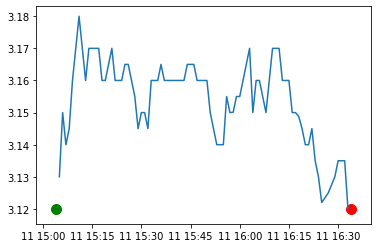

buy time:2020-02-11T15:04:05.944358376Z sell time:2020-02-11T16:33:58.600446962Z
{'rsi': 66.49369745641008, 'macd1': [0.015298608805925706, 0.01456790353548687, 0.013829397656533793, 0.013890917008846149, 0.014578535680785265], 'macd2': [0.022273234684439203, 0.022163145006820262, 0.02202641212867995, 0.022025321364539607, 0.02214902742861602], 'macd_signal': [0.019475450937001225, 0.018493941456698353, 0.01756103269666544, 0.01682700955910158, 0.016377314783438318]}
{'rsi': 33.050999867465165, 'macd': [-0.0050288751530187525, -0.004742851591958086, -0.004458380614612789, -0.004178813871037246, -0.00468592012447111], 'too_close': 1, 'macd_signal': [-0.003289795273253601, -0.003580406536994498, -0.0037560013525181563, -0.0038405638562219744, -0.004009635109871802], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006762850145993083}
buy indicator analysis
slope:-0.00021171327769216043 error=0.00018244842336769996
CCJ analysis for run 

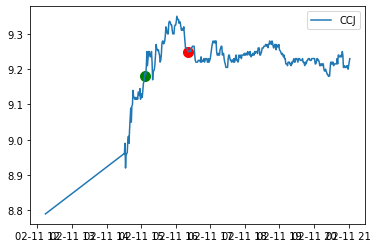

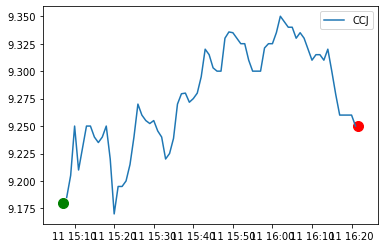

Delta = 0.07000000000000028


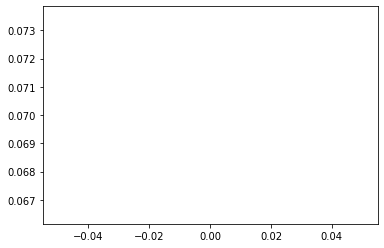

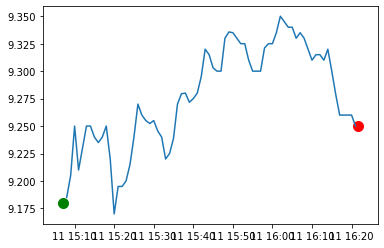

buy time:2020-02-11T15:07:02.621855826Z sell time:2020-02-11T16:21:32.285118661Z
{'rsi': 71.32659223538275, 'macd1': [0.041280722802028436, 0.041279646405921966, 0.041207240153632085, 0.04187749462658452, 0.041925386368907525], 'macd2': [0.051321084465818956, 0.051636931801096964, 0.051924903408963274, 0.05234670391118712, 0.052651052627689765], 'macd_signal': [0.050138838562155515, 0.048367000130908805, 0.04693504813545346, 0.045923537433679676, 0.04512390722072525]}
{'rsi': 28.310527869290198, 'macd': [-0.004091992278681289, -0.006051690324627046, -0.00750013438218744, -0.008531387746749886, -0.009743645073074347], 'too_close': 0, 'macd_signal': [0.0014119378093166142, -8.078781747211791e-05, -0.0015646571304151822, -0.002958003253682123, -0.004315131617560568], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00542851345551378}
buy indicator analysis
slope:0.00018871753544207339 error=7.03954116994016e-05
DHT analysis for run 55


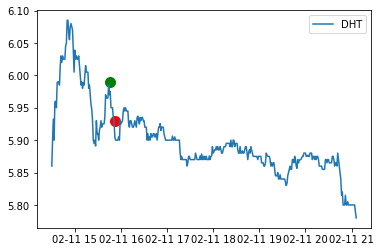

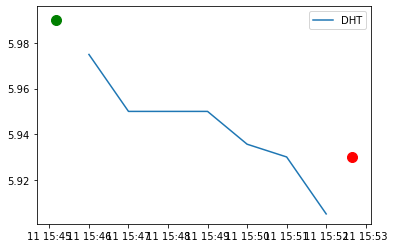

Delta = -0.0600000000000005


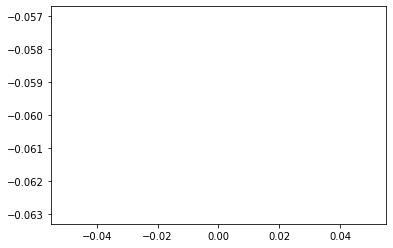

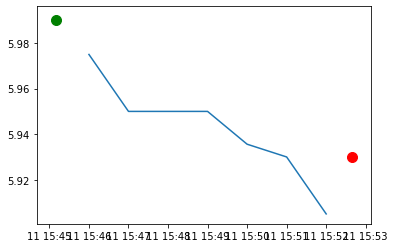

buy time:2020-02-11T15:45:09.540221309Z sell time:2020-02-11T15:52:38.64517477Z
{'rsi': 64.44029133392945, 'macd1': [-0.005164893557571659, -0.0025701594473179767, -0.000507958541024145, 0.002708956226483039, 0.005597320147161966], 'macd2': [0.004979708794661697, 0.005100109615215231, 0.0052027253087914005, 0.005608686048368838, 0.0060531806175703196], 'macd_signal': [-0.01370031268090933, -0.011474282034191059, -0.009281017335557676, -0.006883022623149533, -0.004386954069087233]}
{'rsi': 44.562209805764006, 'macd': [0.0029566575752566493, 0.0024535359508321974, 0.0012815770752956368, 6.080941805564066e-05, -0.0006522668008077659], 'too_close': 1, 'macd_signal': [0.0005452806716548041, 0.0009269317274902828, 0.0009978607970513537, 0.0008104505212522111, 0.0005179070568402157], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0011701738576479815}
buy indicator analysis
slope:0.002680354308326827 error=0.00011022868993771429
UNIT analys

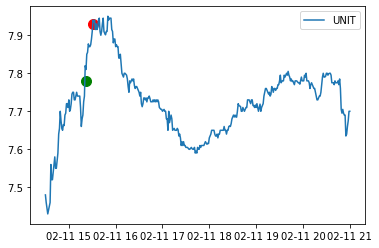

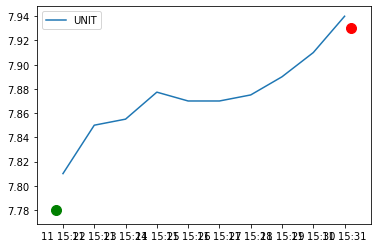

Delta = 0.14999999999999947


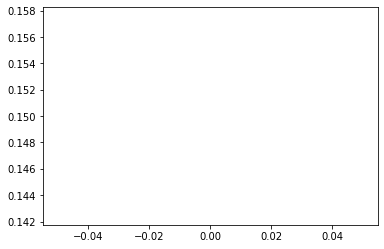

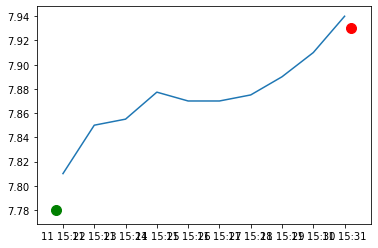

buy time:2020-02-11T15:21:47.442115028Z sell time:2020-02-11T15:31:12.945478522Z
{'rsi': 66.55482765581208, 'macd1': [0.021972722105605413, 0.018543621568472446, 0.018429726599852536, 0.019327048472303154, 0.02300071035559359], 'macd2': [0.05555317375050439, 0.05438070676583795, 0.05377320202422187, 0.05336817954579143, 0.05354993506716266], 'macd_signal': [0.03829121464697077, 0.03434169603127111, 0.031159302144987393, 0.028792851410450546, 0.027634423199479154]}
{'rsi': 78.27840501274177, 'macd': [0.028842560845468768, 0.029938918653792612, 0.030664146573866624, 0.03161024434828974, 0.033495382297862086], 'too_close': 0, 'macd_signal': [0.021173163570354852, 0.022926314587042404, 0.024473880984407247, 0.025901153657183745, 0.027419999385319412], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.006075382912542674}
buy indicator analysis
slope:0.00028394034038070615 error=0.0007484385146129743
GUSH analysis for run 55


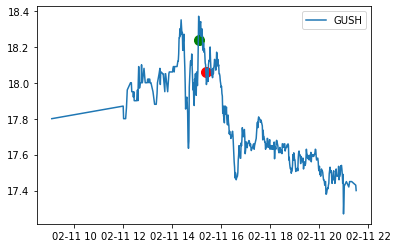

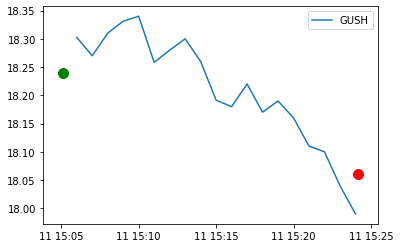

Delta = -0.17999999999999972


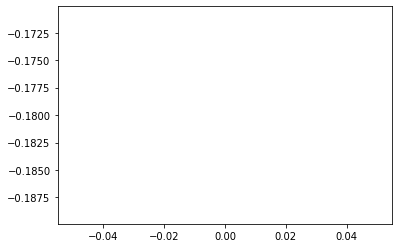

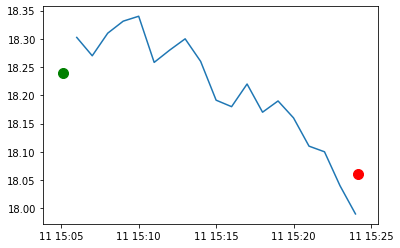

buy time:2020-02-11T15:05:05.224708653Z sell time:2020-02-11T15:24:07.975701261Z
{'rsi': 61.81178109427316, 'macd1': [0.08963684305000541, 0.08223460535789329, 0.08155268573748842, 0.0937540001575421, 0.10372877356177312], 'macd2': [0.1258189456875165, 0.12476356418861911, 0.12480695199920788, 0.12738696301246932, 0.12985439903384943], 'macd_signal': [0.11561462409420162, 0.10893862034693995, 0.10346143342504964, 0.10151994677154813, 0.10196171212959312]}
{'rsi': 42.52783728758026, 'macd': [0.02550847022144964, 0.01827027244338808, 0.011873361545632122, 0.0036176730338013385, -0.0018233527291009466], 'too_close': 0, 'macd_signal': [0.044045120414760344, 0.03889015082048589, 0.03348679296551514, 0.02751296897917238, 0.021645704637517714], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.02346905736661866}
buy indicator analysis
slope:0.003970325582318424 error=0.002425989469541272


In [76]:
for run_id, count in runs.items():
    for symbol in minute_history:
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)


        for trade in trade_details[run_id][symbol]:
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)

        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
        for trade in trade_details[run_id][symbol]:
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])
